# Exercise for Chapter 2 (Solutions)

In [248]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
import seaborn as sns

register_matplotlib_converters()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

from arch import arch_model

from scipy.stats import ttest_1samp

In [249]:
pd.options.display.max_columns = None
pd.options.display.width=None
sns.set(style="darkgrid")

### Exercise 1

Consider the exchange rate daily data from December 4, 2006 to November 5, 2010 (Rupee versus Dollar, Pound and Euro), in file exchange_rates_1.csv.
1. Compute the sample average, standard deviation and the first order autocorrelation of daily returns over the entire sample period.
Test if the mean and the first order autocorrelation are significantly different from zero using the tests proposed in Section 2.6.

2. Plot histograms of the returns over the entire sample period; Does the distribution look normal? Test it through Jarque-Bera test in (2.37).

3. Aggregate the data at the weekly level. Repeat (1) and (2) on the aggregated data. Compare the result with the result for the daily level.


#### Part 1

Let's load the data look at a few rows and then plot to see what the data looks like.

In [250]:
fx_prices = pd.read_csv('../datasets/exchange_rates_1.csv',index_col='Date',parse_dates=['Date'])
fx_prices.columns = ['USDINR','GBPINR','EURINR']
fx_prices.round(2).head()

,USDINR,GBPINR,EURINR
Date,,,
2006-12-04,44.59,88.24,59.40
2006-12-05,45.10,89.27,60.17
2006-12-06,44.69,87.95,59.38
2006-12-07,44.66,87.94,59.44
2006-12-08,44.66,87.60,59.34


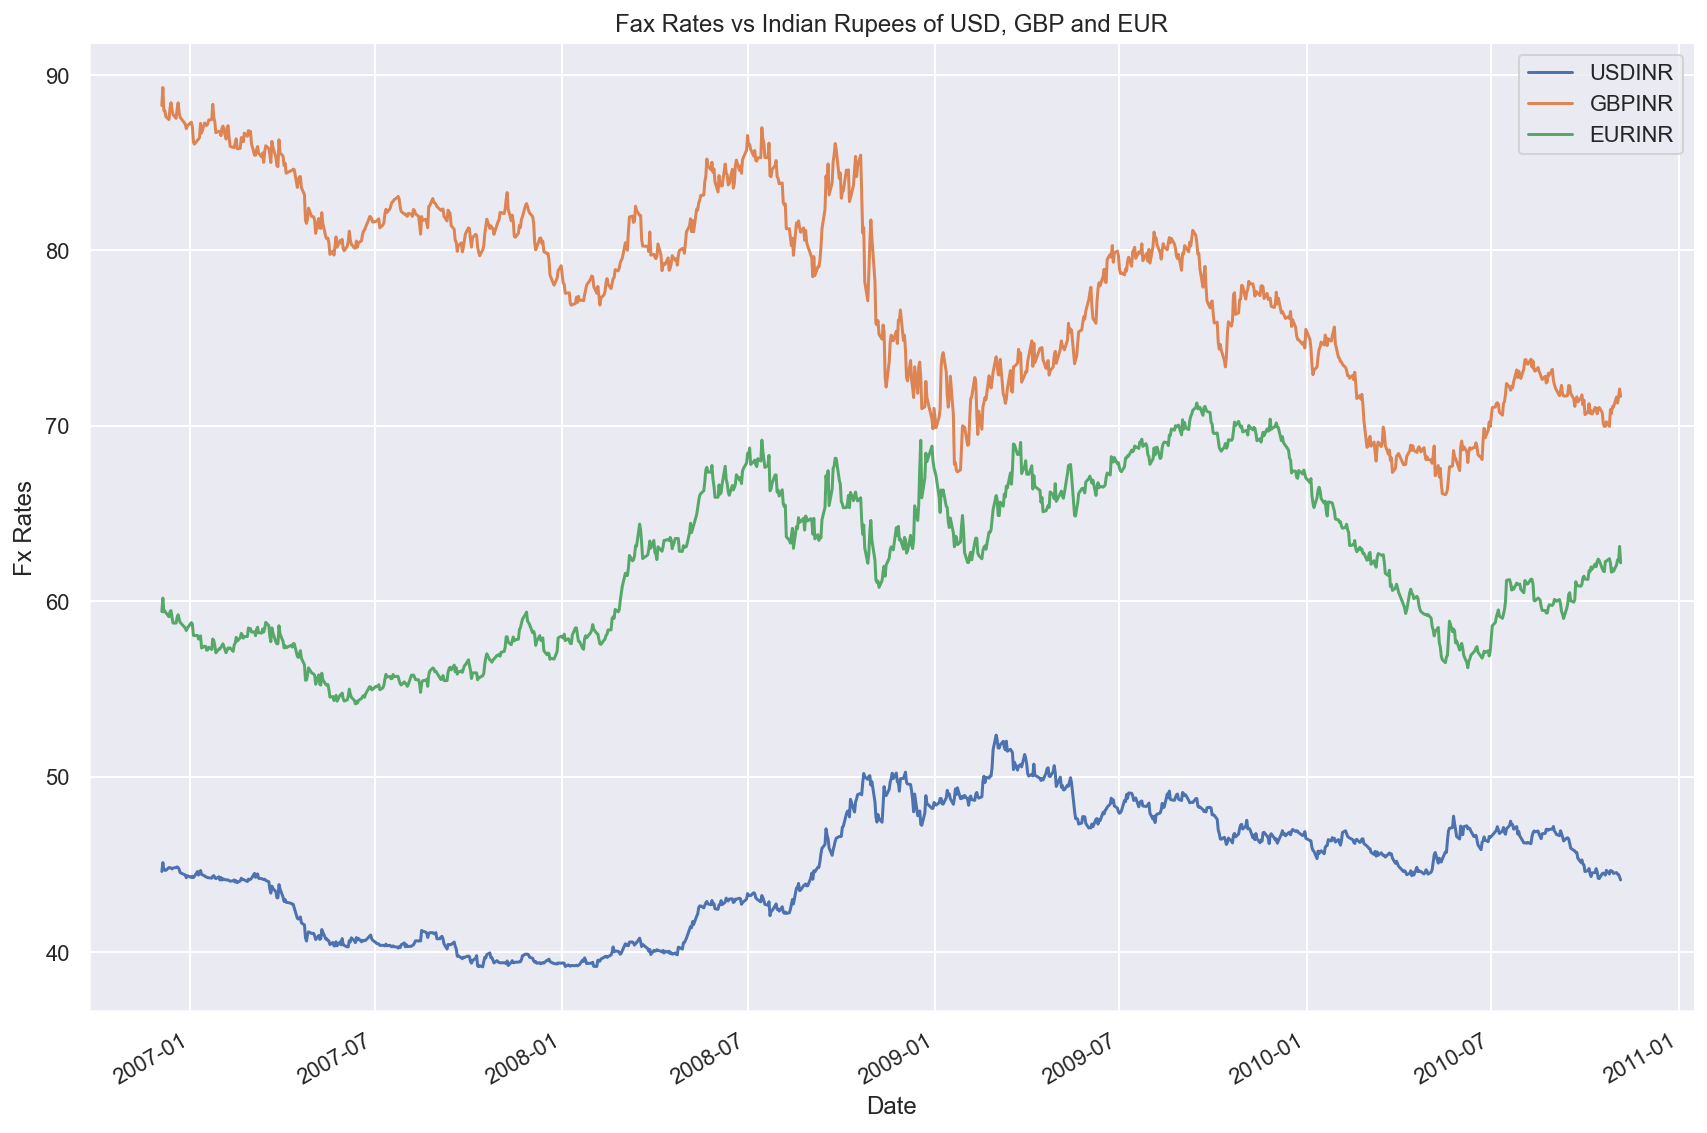

In [251]:
fig,ax = plt.subplots(figsize=(12,8))
_ = fx_prices.plot(ax = ax)
_ = plt.ylabel('Fx Rates')
_ = plt.title('Fax Rates vs Indian Rupees of USD, GBP and EUR')
sns.despine()
plt.tight_layout()
plt.show()

Let's generate the returns and have a quick look

In [252]:
fx_returns = fx_prices.pct_change().dropna().round(4)
fx_returns.round(4).head()

,USDINR,GBPINR,EURINR
Date,,,
2006-12-05,0.0114,0.0117,0.0130
2006-12-06,-0.0089,-0.0148,-0.0132
2006-12-07,-0.0008,-0.0001,0.0009
2006-12-08,-0.0000,-0.0038,-0.0016
2006-12-11,0.0036,-0.0019,-0.0039


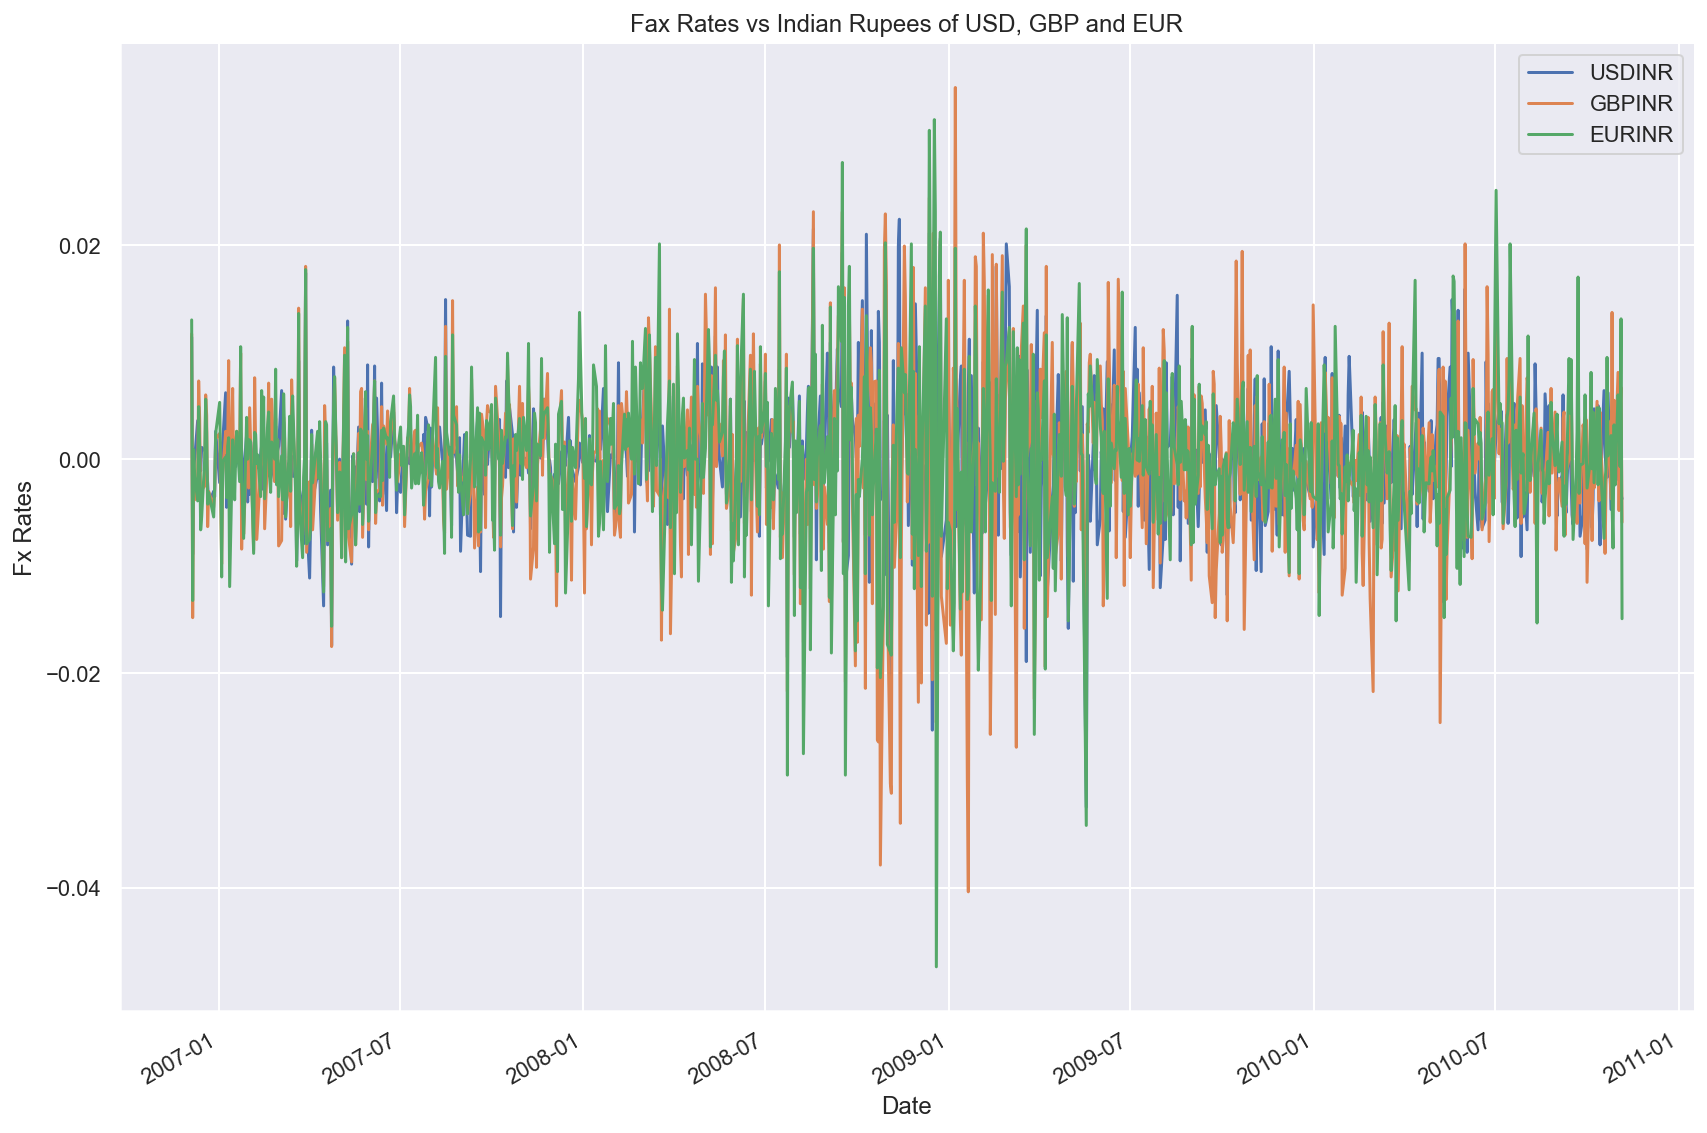

In [253]:
fig,ax = plt.subplots(figsize=(12,8))
_ = fx_returns.plot(ax = ax)
_ = plt.ylabel('Fx Rates')
_ = plt.title('Fax Rates vs Indian Rupees of USD, GBP and EUR')
sns.despine()
plt.tight_layout()
plt.show()

Let's review the main statistics of the returns:

In [254]:
stats = pd.concat({'mean':fx_returns.mean(axis=0),'std':fx_returns.std(axis=0),'autocorr':fx_returns.apply(lambda s: s.autocorr(lag=1))},axis=1)
stats

,mean,std,autocorr
USDINR,0.000006,0.005638,-0.047870
GBPINR,-0.000174,0.008085,-0.016840
EURINR,0.000074,0.007261,-0.053214


To test the hypohtesis that the means are zero let's first do a one sample t-test analysis:

In [255]:
ttest_tstats, ttest_pv = ttest_1samp(fx_returns,0)
print(f'p-values for one sample t-test:\n{ttest_pv}')

p-values for one sample t-test:
[0.97496084 0.49723581 0.74677083]


All three p-values are greater than zero, so we don’t have enough evidence to reject the null hypothesis that
mean equals zero.

We then look at 1 lag autocorrelation using the Ljung-Box test for autocorrelation of residuals:

In [256]:
lbox_pvalues = [acorr_ljungbox(fx_returns.loc[:,curr],lags=1)[1][0] for curr in fx_returns.columns]
print(f'p-values for one LJung-Box test:\n{lbox_pvalues}')

p-values for one LJung-Box test:
[0.1301733426993926, 0.5940867526678513, 0.09295756910584677]


All three p-values are greater than zero, so we don’t have enough evidence to reject the null hypothesis that the ACF of lag 1 equals zero

#### Part 2

Let's plot the histograms of returns:

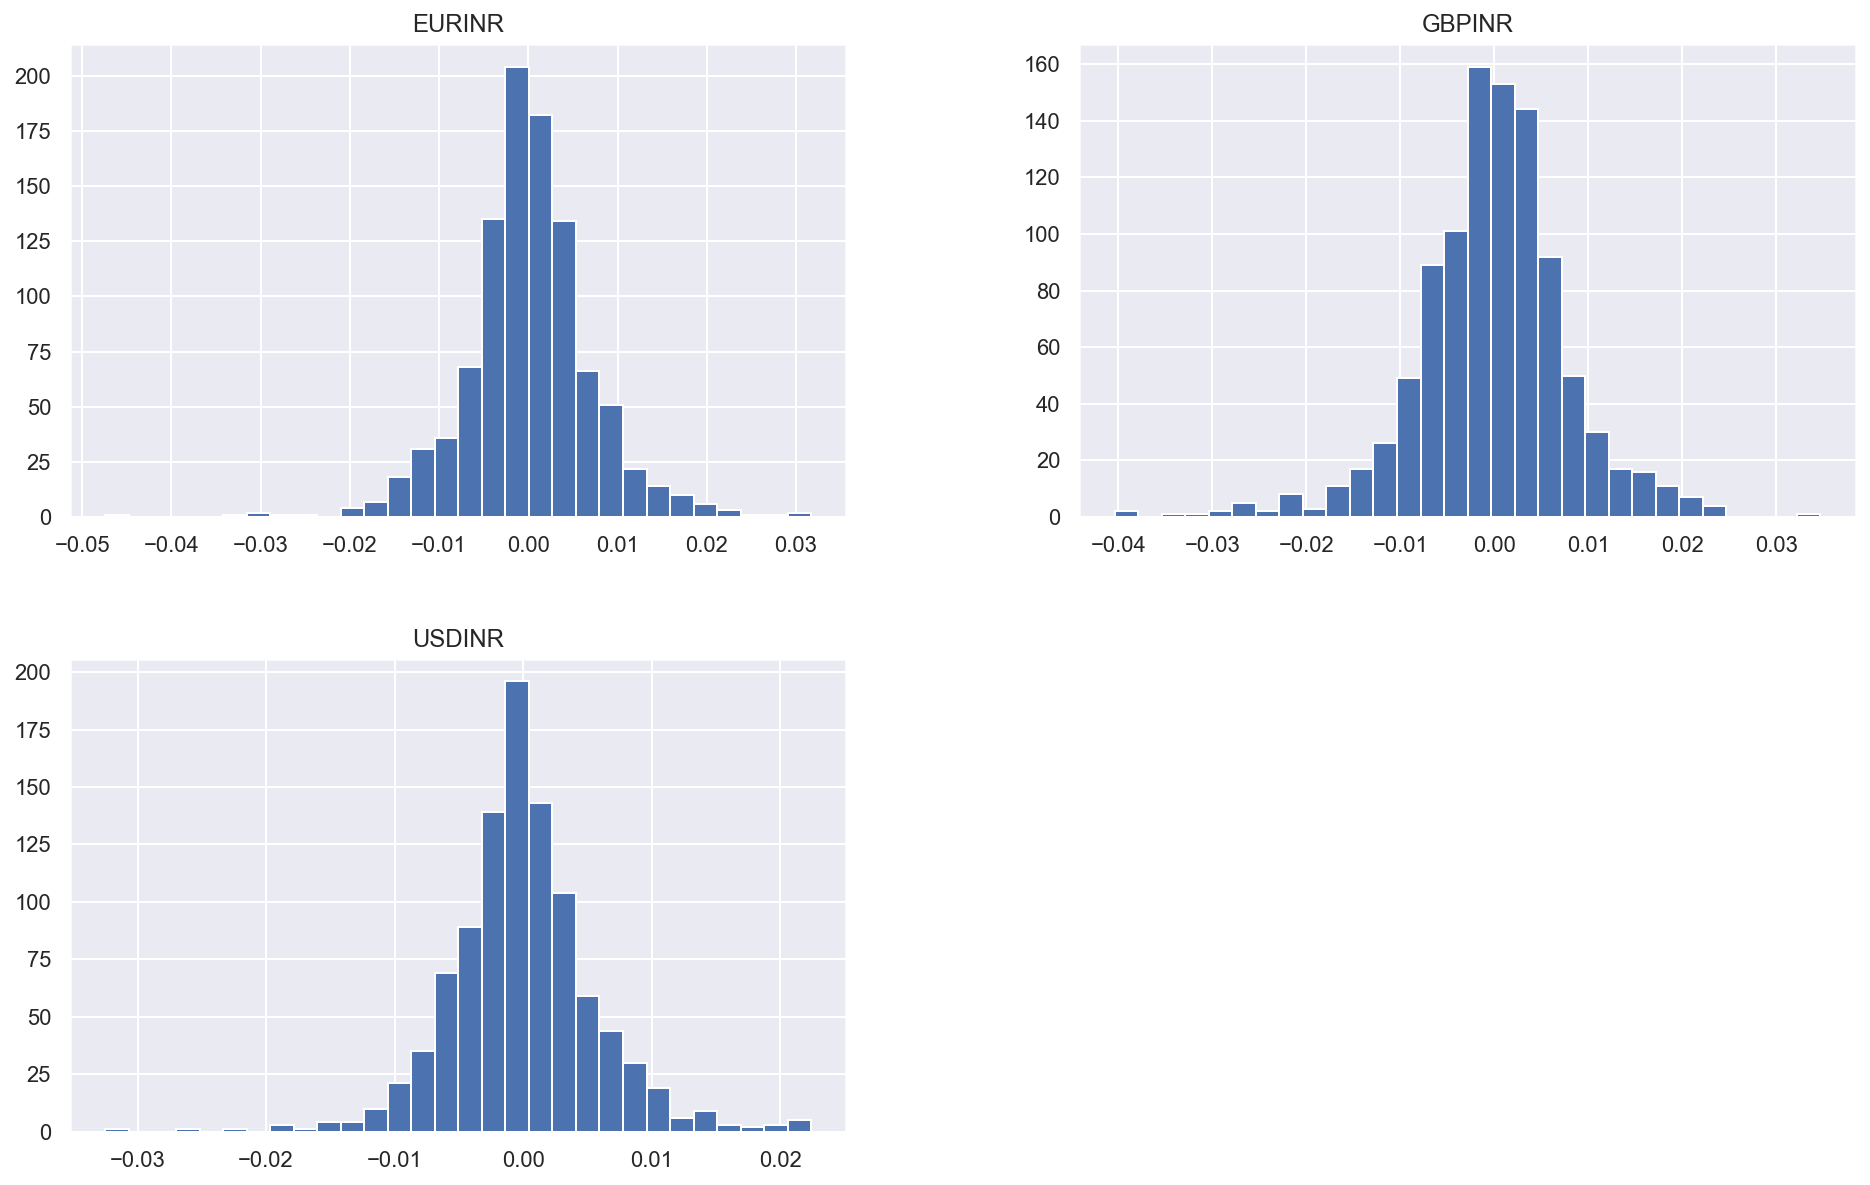

In [257]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
_ = fx_returns.hist(bins=30,ax=ax.reshape(4)[0:3])
_ = ax[1,1].set_visible(False)
plt.show()

The returns do not look particularly normal. Notice the higher than normal kurtosis and skew. We use the Jarque-Bera for goodness of fit

In [258]:
jb_test_pv = jarque_bera(fx_returns)[1]
print(f'p-values for jarque_bera Test:\n{jb_test_pv}')

p-values for jarque_bera Test:
[5.38927612e-085 1.84647412e-066 3.76467431e-140]


The p-values are essentially 0 thus we need to reject the hypothesis that the returns are normal

#### Part 3

Let's resample the data to create a weekly dataset and re-run all out analysis.

In [259]:
fx_weekly_prices = fx_prices.resample('W').first()
fx_weekly_returns = fx_weekly_prices.apply(lambda s: np.log(s) - np.log(s).shift(1),axis=0).dropna()

In [260]:
weekly_stats = pd.concat({'mean':fx_weekly_returns.mean(axis=0),'std':fx_weekly_returns.std(axis=0),'autocorr':fx_weekly_returns.apply(lambda s: s.autocorr(lag=1))},axis=1)
weekly_stats

,mean,std,autocorr
USDINR,-0.000007,0.011966,0.115449
GBPINR,-0.001022,0.016916,-0.123775
EURINR,0.000215,0.014977,-0.059014


In [261]:
ttest_tstats, ttest_pv = ttest_1samp(fx_weekly_returns,0)
print(f'p-values for one sample t-test:\n{ttest_pv}')

p-values for one sample t-test:
[0.99326437 0.38909941 0.83770731]


In [262]:
lbox_pvalues = [acorr_ljungbox(fx_weekly_returns.loc[:,curr],lags=1)[1][0] for curr in fx_returns.columns]
print(f'p-values for one LJung-Box test:\n{lbox_pvalues}')

p-values for one LJung-Box test:
[0.09685847108112841, 0.07660584576684498, 0.39617349788492895]


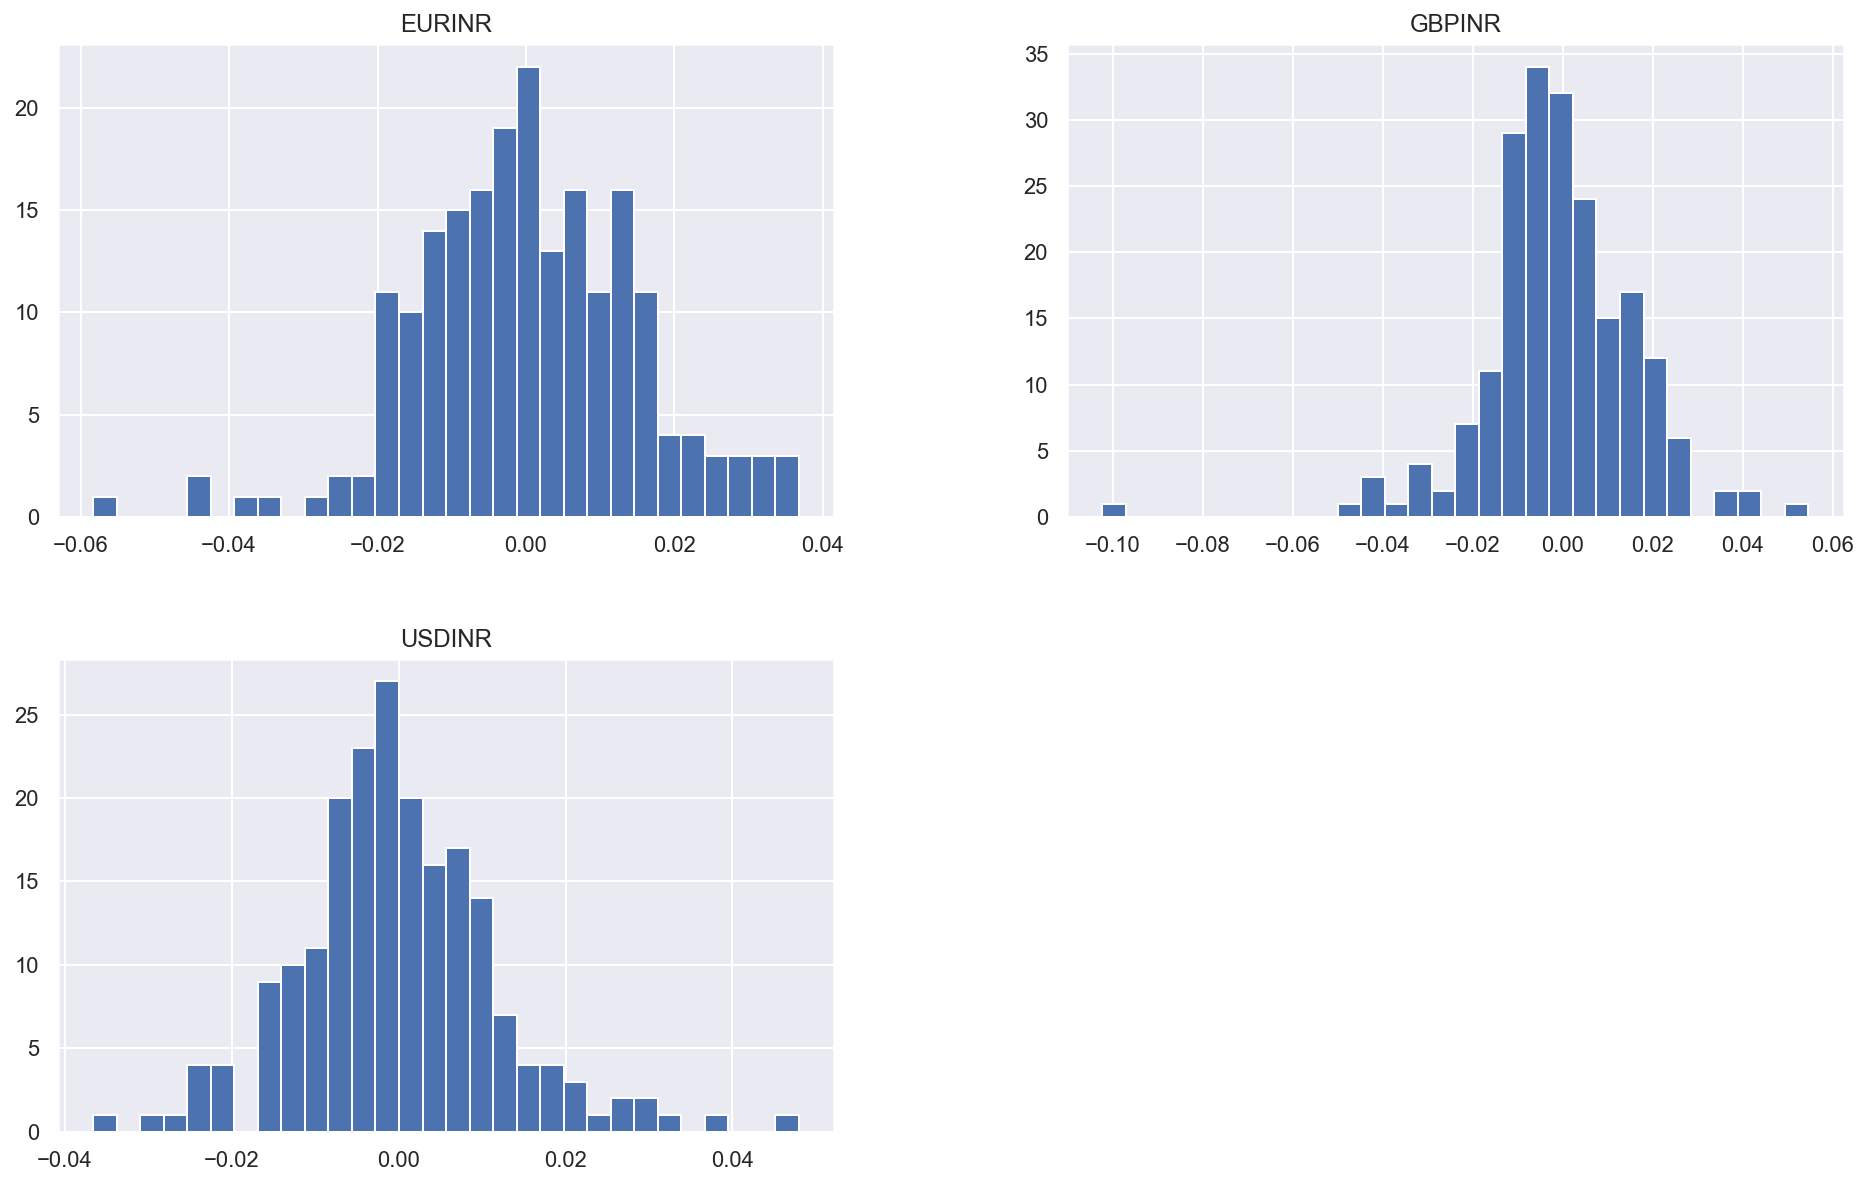

In [263]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
_ = fx_weekly_returns.hist(bins=30, ax=ax.reshape(4)[0:3])
_ = ax[1,1].set_visible(False)
plt.show()

In [264]:
jb_test_pv = jarque_bera(fx_weekly_returns)[1]
print(f'p-values for jarque_bera Test:\n{jb_test_pv}')

p-values for jarque_bera Test:
[2.34731094e-07 2.35545812e-77 4.07331729e-03]


The analysis confirms that the results still hold if we look at weekly data:

- Cannot reject mean different than 0
- Cannot reject that there is no autocorrelation on lag 1
- Must reject that the sample is normally distributed

### Exercise 2

For the returns of all three time series in Problem 1, construct...
1. ARMA models for the returns. Identify the model structure via ACF and PACF.
2. GARCH models for the squared returns; compare the model coefficients for the three series. Comment on the difference, if any.
3. Is there a co-movement among the three exchange-rate series? To make the plots on a comparable scale, convert the starting points of the series unity. Does the
co-movement vary over different time regimes? (Back up your claim with solid analysis.) Identify the transition states and speculate how you can exploit this for
trading decisions.

#### Part 1 ARMA Modeling

##### USDINR

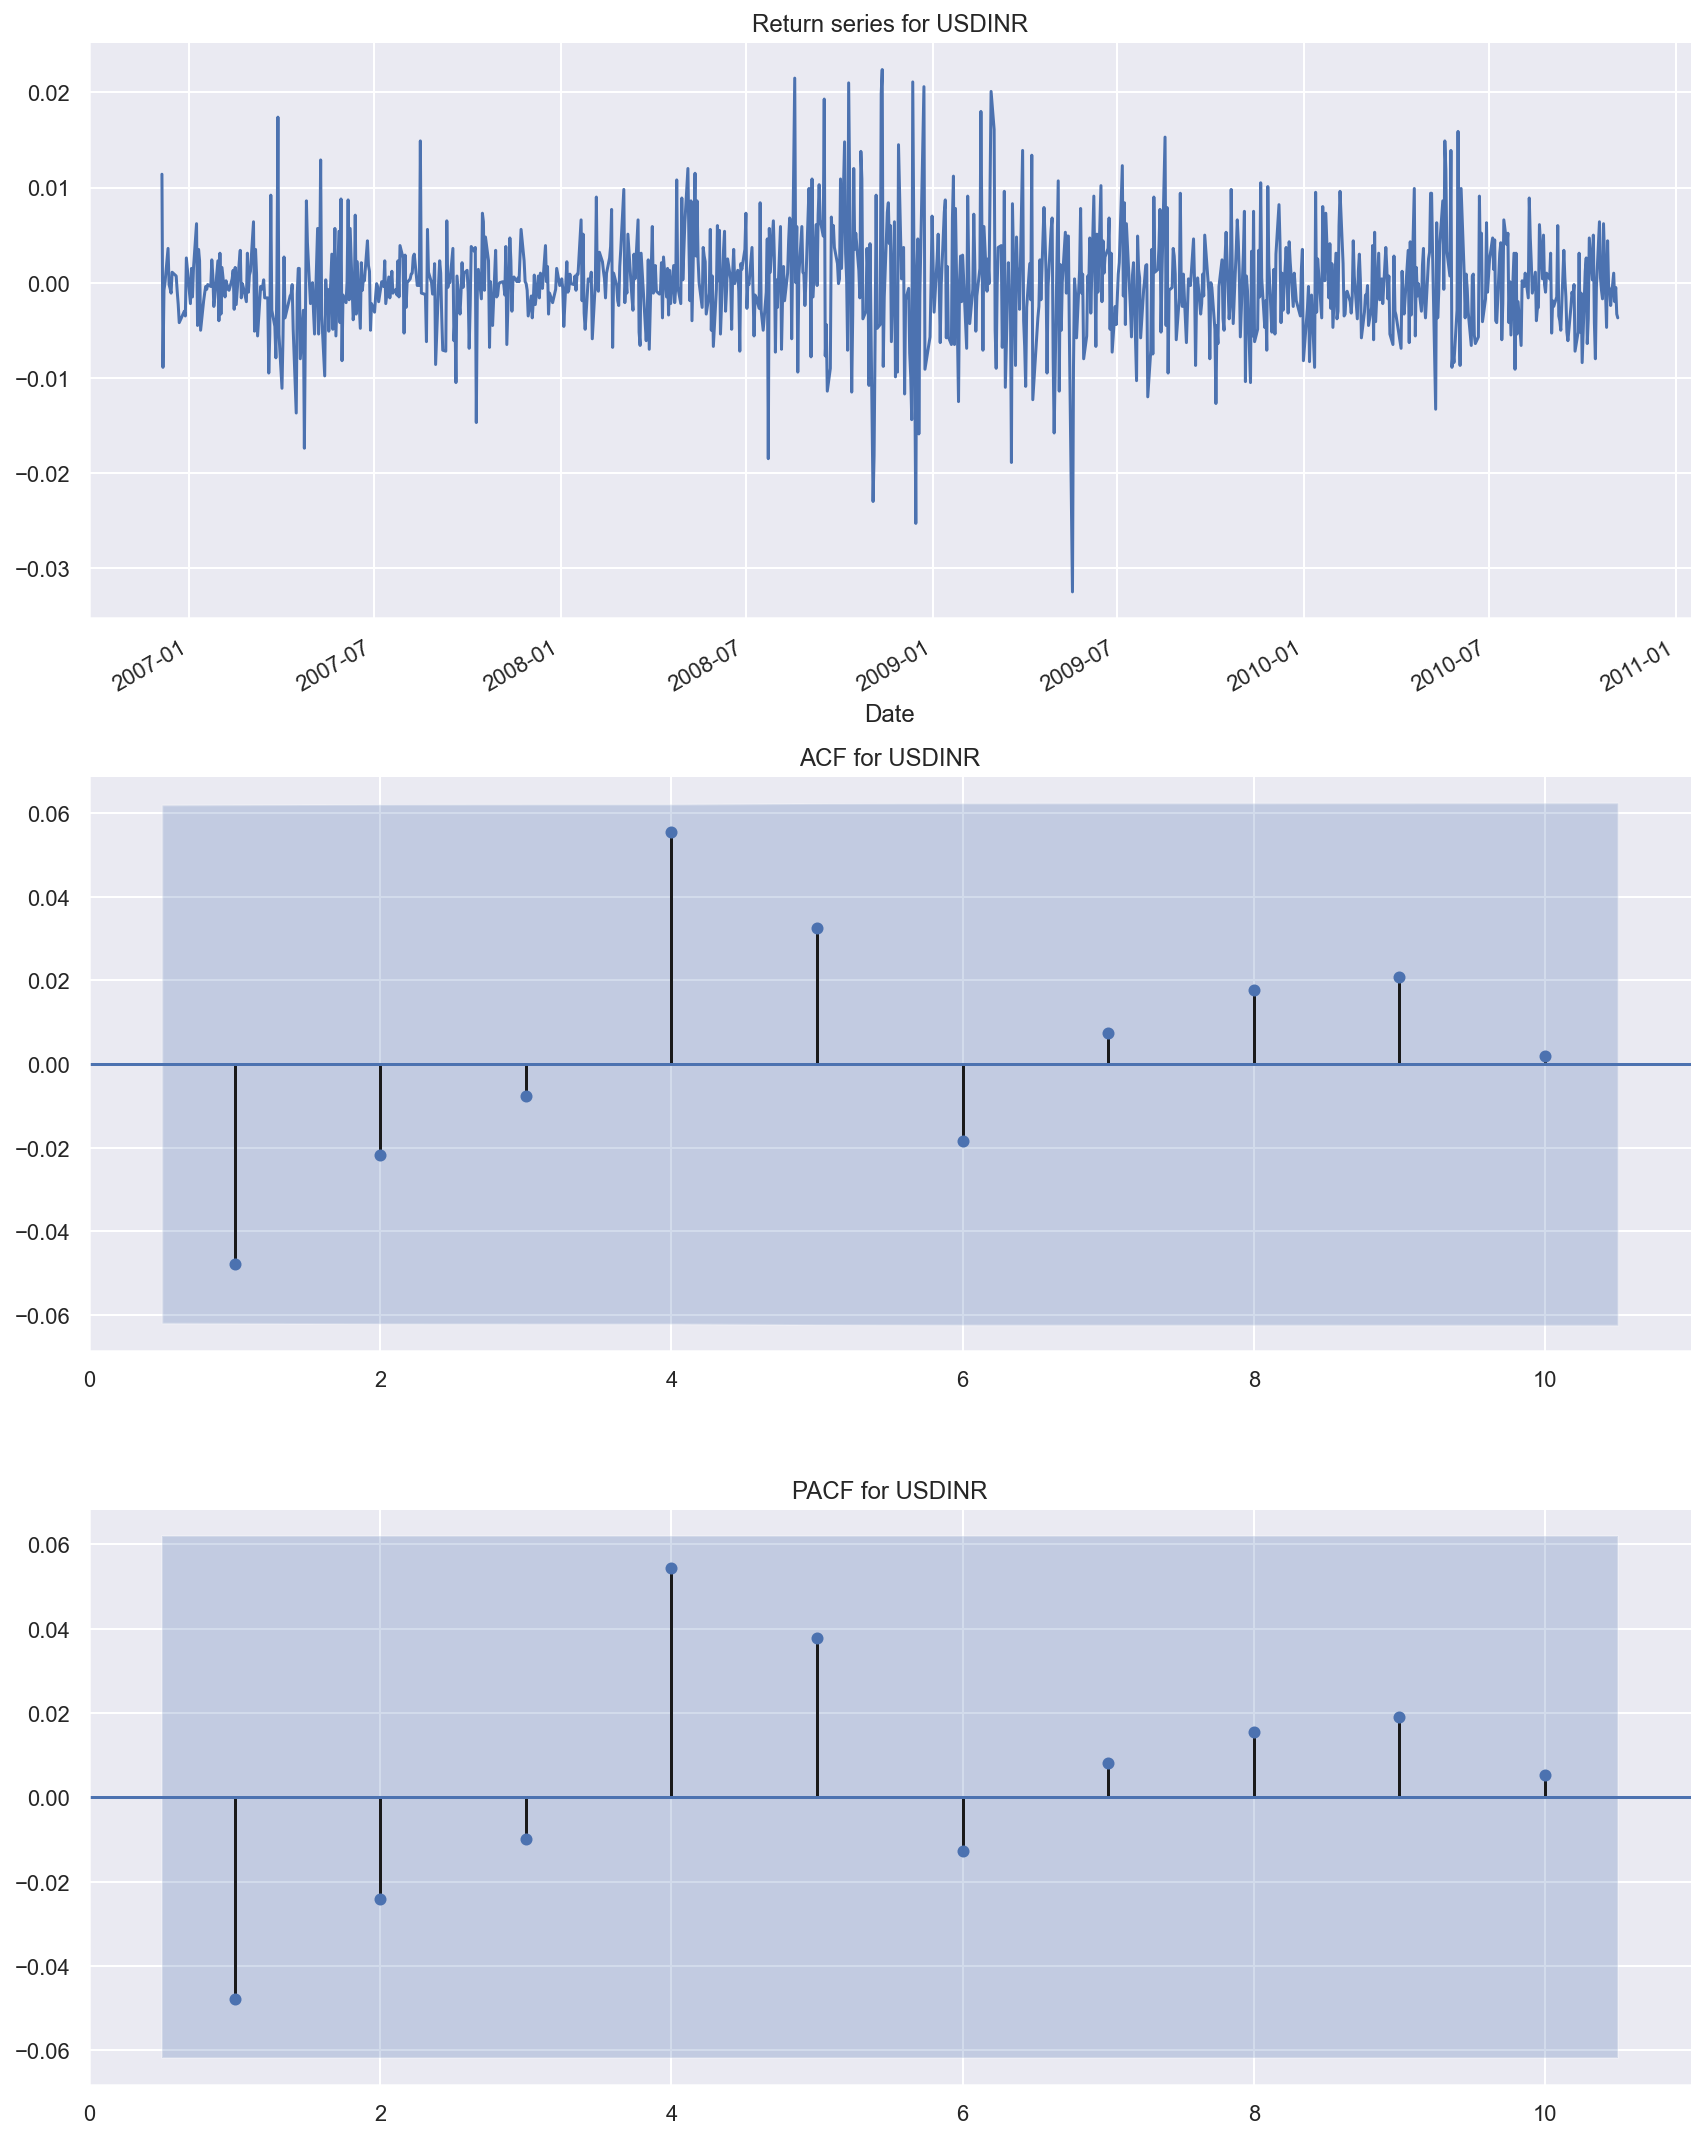

In [265]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.USDINR.plot(ax=ax1,title='Return series for USDINR')
_ = plot_acf(fx_returns.USDINR, ax=ax2,zero=False,alpha=0.05,lags=10,title='ACF for USDINR')
_ = plot_pacf(fx_returns.USDINR, ax=ax3,zero=False,alpha=0.05,lags=10,title='PACF for USDINR')
sns.despine()
plt.tight_layout()
plt.show()

The ACF and PACF show little or more significance at any lag.
Returns look little more than white noise so no real point running an ARMA modeling.

##### GBPINR

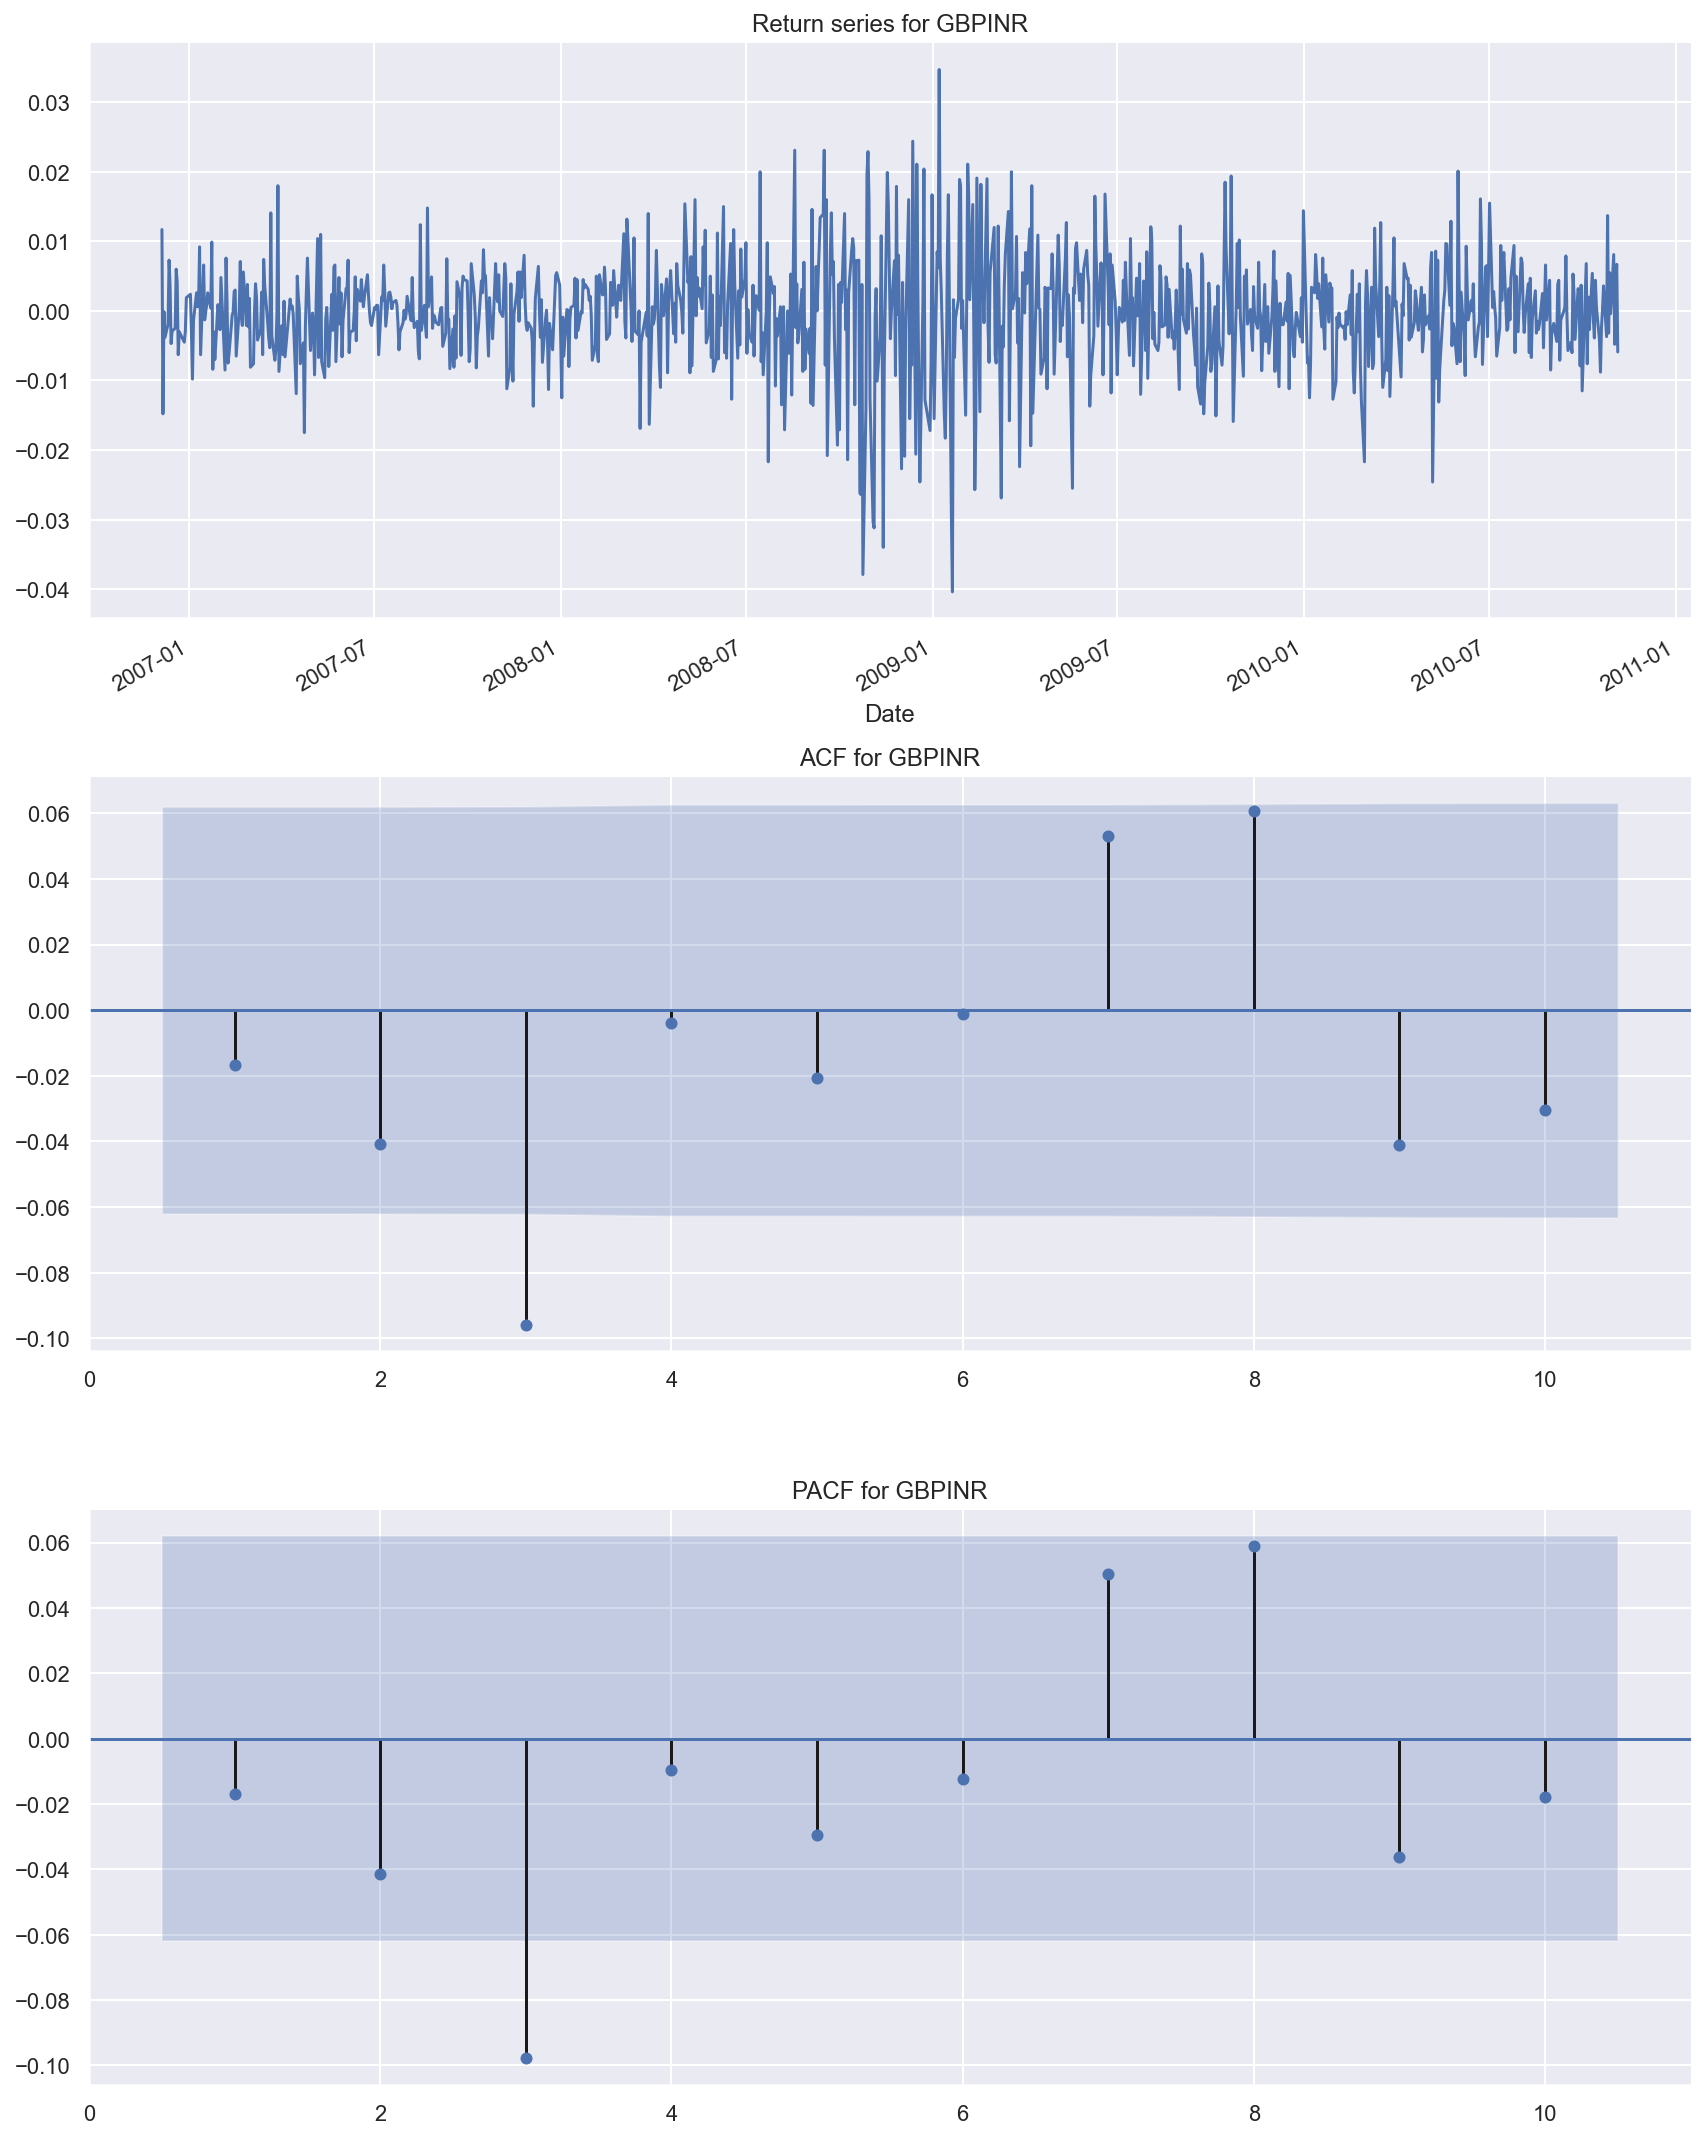

In [266]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.GBPINR.plot(ax=ax1,title='Return series for GBPINR')
_ = plot_acf(fx_returns.GBPINR, ax=ax2,zero = False,alpha=0.05,lags=10,title='ACF for GBPINR')
_ = plot_pacf(fx_returns.GBPINR, ax=ax3, zero = False,alpha=0.05,lags=10,title='PACF for GBPINR')
sns.despine()
plt.tight_layout()
plt.show()

The series show small but releavant ACF at lag 3 and so does the PACF. This could imply an ARMA(3,3). We are using the ARIMA implementation of the stats model package

In [272]:
results = ARIMA(fx_returns.GBPINR,(3,0,3)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 GBPINR   No. Observations:                 1001
Model:                     ARMA(3, 3)   Log Likelihood                3409.325
Method:                       css-mle   S.D. of innovations              0.008
Date:                Tue, 15 Sep 2020   AIC                          -6802.650
Time:                        12:47:59   BIC                          -6763.380
Sample:                             0   HQIC                         -6787.726
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.000     -0.829      0.407      -0.001       0.000
ar.L1.GBPINR    -0.2366      0.227     -1.044      0.296      -0.681       0.208
ar.L2.GBPINR    -0.1715      0.191     -0.900      0.368      -0.545       0.202
ar.L3.GBPINR     0.3563      0.239      1.491      0.136      -0.112       0.824
ma.L1.GBPINR     0.2112      0.215      0.984      0.325      -0.209       0.632
ma.L2.GBPINR     0.1231      0.181      0.678      0.498      -0.233       0.479
ma.L3.GBPINR    -0.4626      0.228     -2.031      0.042      -0.909      -0.016
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6404           -1.0875j            1.2621           -0.3347
AR.2           -0.6404           +1.0875j            1.2621            0.3347
AR.3            1.7621           -0.0000j            1.7621           -0.0000
MA.1           -0.6233           -1.0201j            1.1954           -0.3373
MA.2           -0.6233           +1.0201j            1.1954            0.3373
MA.3            1.5126           -0.0000j            1.5126           -0.0000
-----------------------------------------------------------------------------
"""

Most of the coefficients are non significant so the model seems overspecificied. Let's try a simpler ARMA(1,1) model

In [278]:
results = ARIMA(fx_returns.GBPINR,(1,0,1)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 GBPINR   No. Observations:                 1001
Model:                     ARMA(1, 1)   Log Likelihood                3403.279
Method:                       css-mle   S.D. of innovations              0.008
Date:                Tue, 15 Sep 2020   AIC                          -6798.558
Time:                        12:50:15   BIC                          -6778.923
Sample:                             0   HQIC                         -6791.096
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.000     -0.688      0.492      -0.001       0.000
ar.L1.GBPINR    -0.8320      0.153     -5.452      0.000      -1.131      -0.533
ma.L1.GBPINR     0.8142      0.159      5.125      0.000       0.503       1.126
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2019           +0.0000j            1.2019            0.5000
MA.1           -1.2281           +0.0000j            1.2281            0.5000
-----------------------------------------------------------------------------
"""

A little better but not likely really a strongly predicting relationship.

##### EURINR

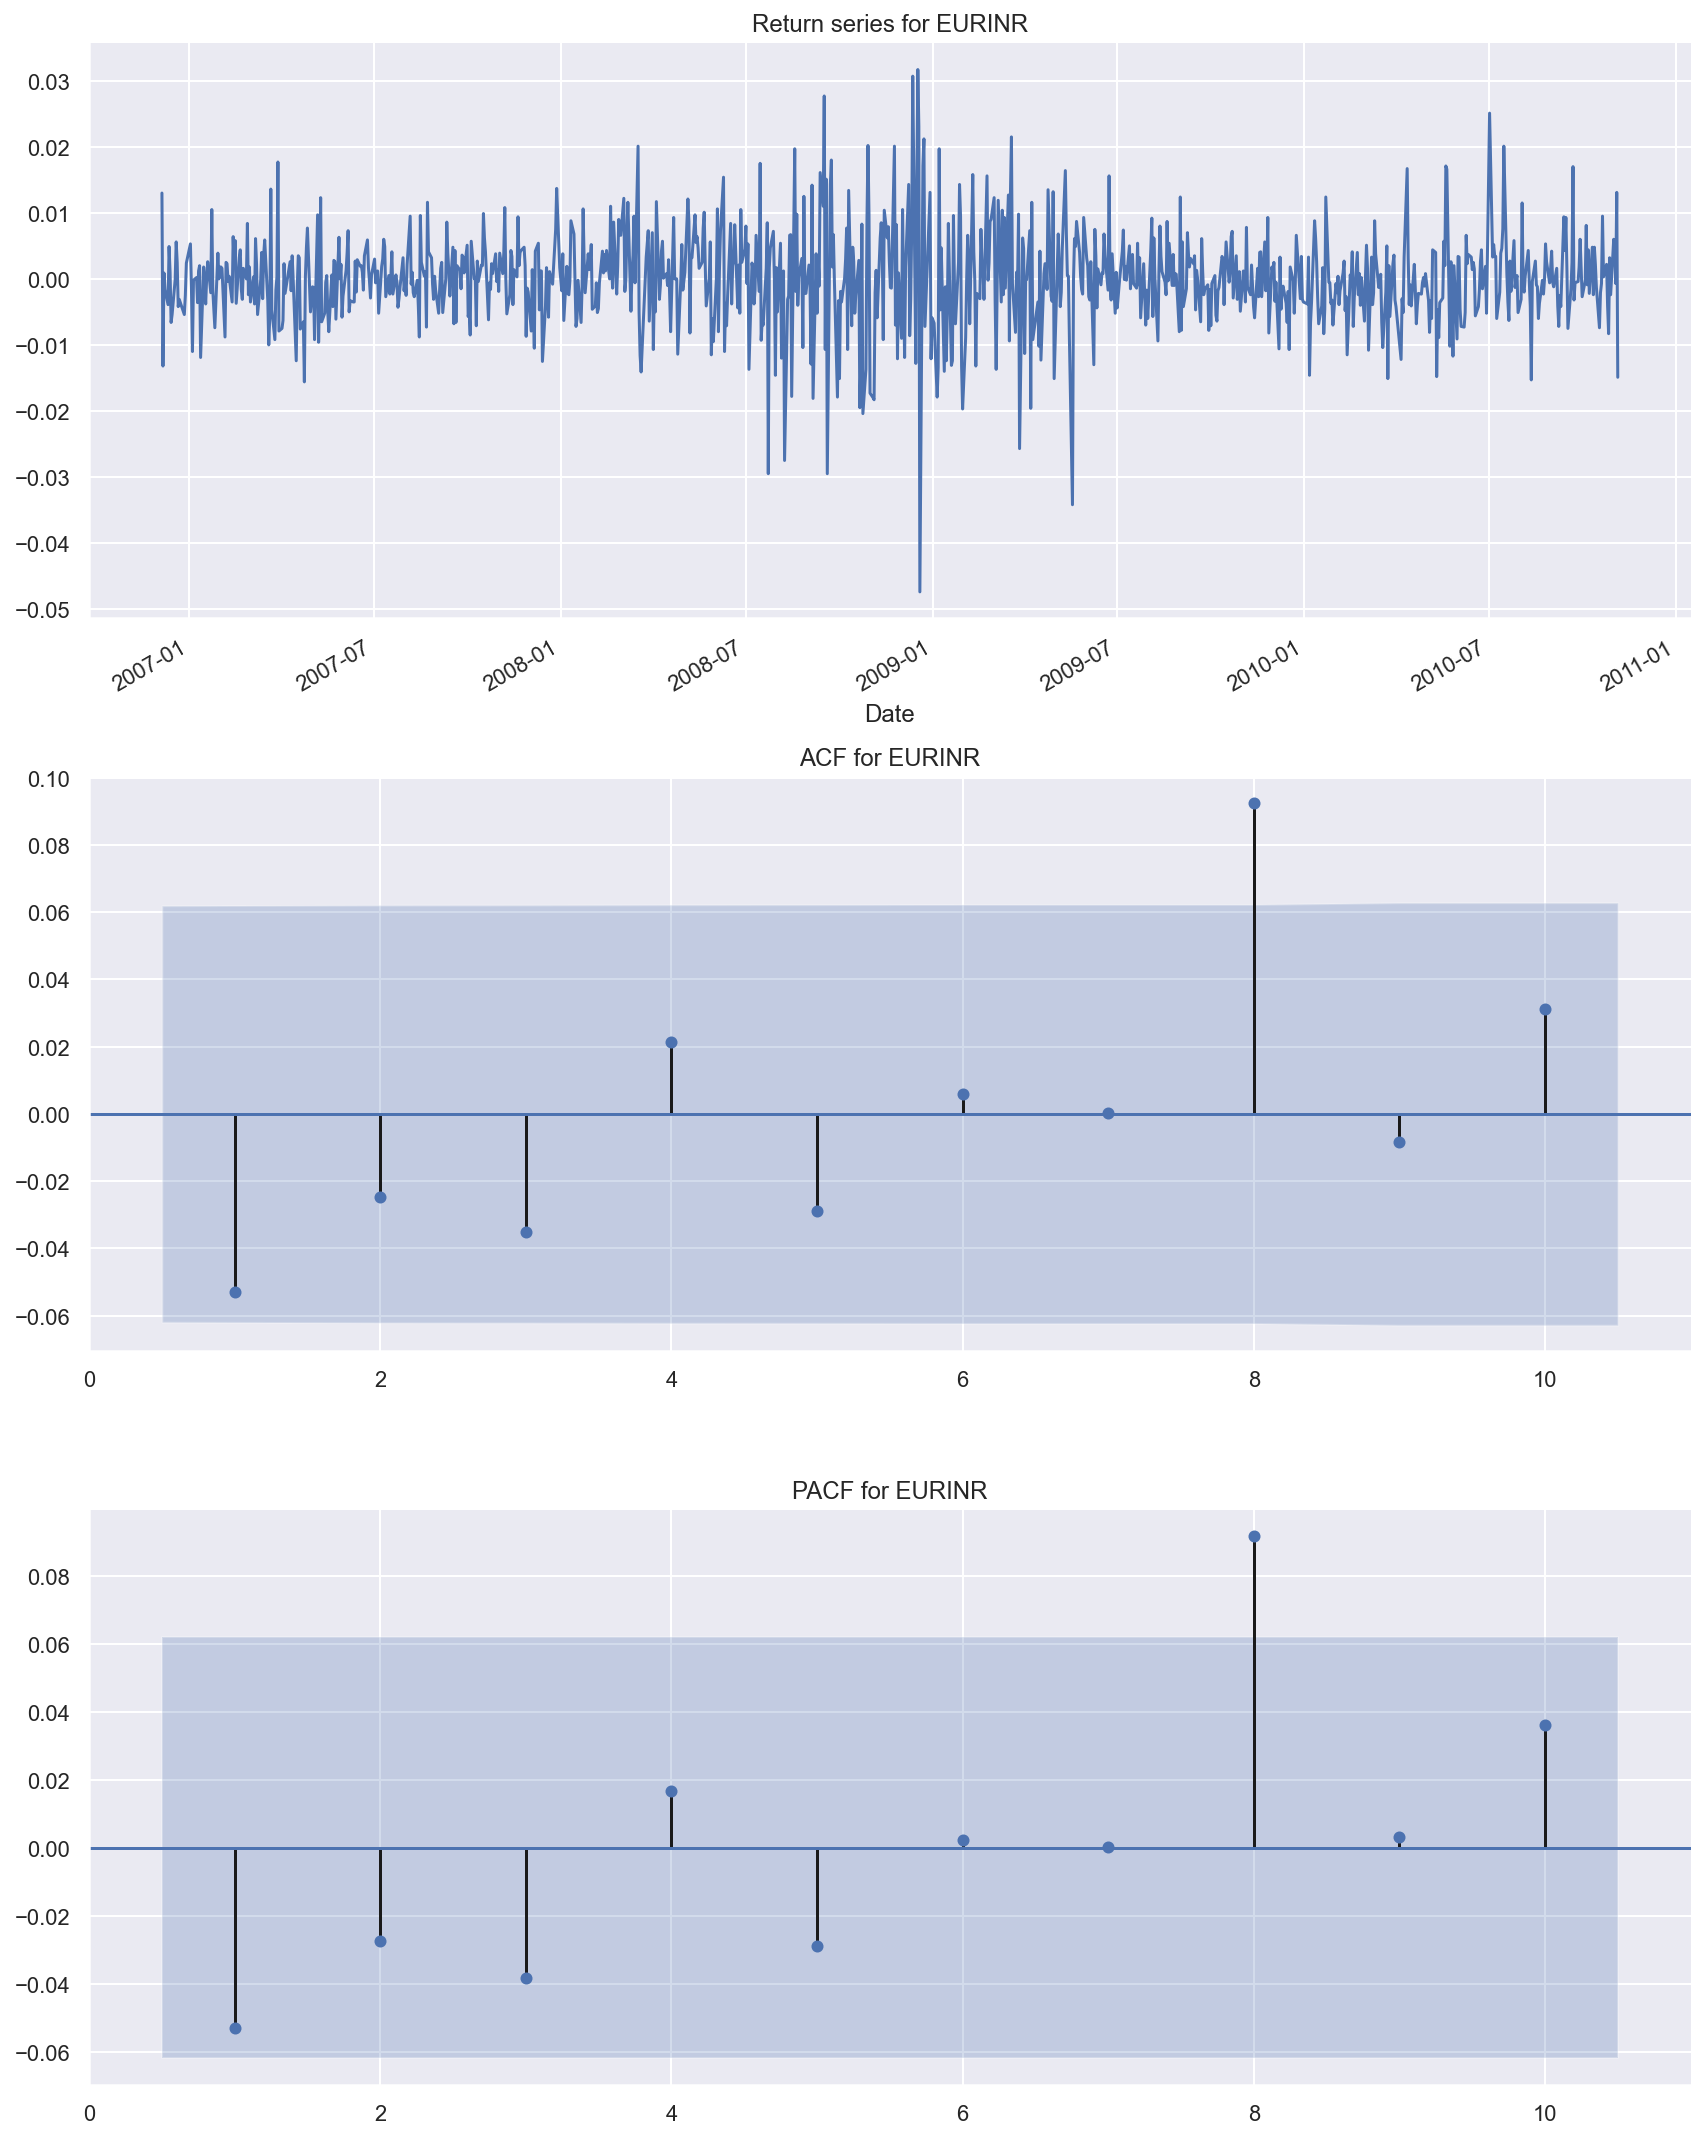

In [279]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.EURINR.plot(ax=ax1,title='Return series for EURINR')
_ = plot_acf(fx_returns.EURINR, ax=ax2,zero = False,alpha=0.05,lags=10,title='ACF for EURINR')
_ = plot_pacf(fx_returns.EURINR, ax=ax3, zero = False,alpha=0.05,lags=10,title='PACF for EURINR')
sns.despine()
plt.tight_layout()
plt.show()



The ACF and PACF show only significance at lag 7 so very weak dependency. No real point running an ARMA modeling.

#### Part 2 GARCH Modeling


We'll use the arch package to fit the time series


##### USDINR

In [22]:
am = arch_model(fx_returns.USDINR)
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.346434436222032e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.42753773409707e+26
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.9721936693701143e+22
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2083615611722199.2
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.65091332932914e+20
Iteration:      6,   Func. Count:     76,   Neg. LLF: 8795446818084500.0
Iteration:      7,   Func. Count:     91,   Neg. LLF: 3.878710911402228e+20
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6733602488270100.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3854.3176772261477
            Iterations: 12
            Function evaluations: 113
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 USDINR   R-squared:                      -0.000
Mean Model:             Constant 

### Question 5

Consider the daily price of Apple stock from January 2, 2015 to January 2, 2018 in file aapl_daily.csv. The data have 7 columns (namely, Date, Open, High, Low, Close, Volume, Adj Close). We focus on the adjusted closing price in the last column:
1. Compute the daily log returns. Is there any serial correlation in the daily log returns? Use the test for white noise as outlined in the text.
2. Consider the pivot based on the average of high and low price and the pivot based on the average of high, low and close prices. Compute the returns based on the pivot log prices and test for serial correlation. Compare this result with the finding in (1).
3. Consider the log price series of AAPL stock. Is the log price series unit-root non-stationary? Perform a unit-root (Dickey-Fuller) test to answer the question and present your conclusion.

In [58]:
aapl = pd.read_csv('../datasets/aapl_daily.csv',index_col='Date',parse_dates=True).rename(columns={'Adj Close':'AdjClose'})
aapl.head()

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2015-01-02,111.389999,111.440002,107.349998,109.330002,101.963631,53204600
2015-01-05,108.290001,108.650002,105.410004,106.250000,99.091148,64285500
2015-01-06,106.540001,107.430000,104.629997,106.260002,99.100471,65797100
2015-01-07,107.199997,108.199997,106.699997,107.750000,100.490089,40105900
2015-01-08,109.230003,112.150002,108.699997,111.889999,104.351151,59364500


#### Part 1

In [60]:
aapl_lr = np.log(aapl.AdjClose).diff().dropna()
aapl_lr.head()

Date
2015-01-05   -0.028576
2015-01-06    0.000094
2015-01-07    0.013925
2015-01-08    0.037703
2015-01-09    0.001072
Name: AdjClose, dtype: float64

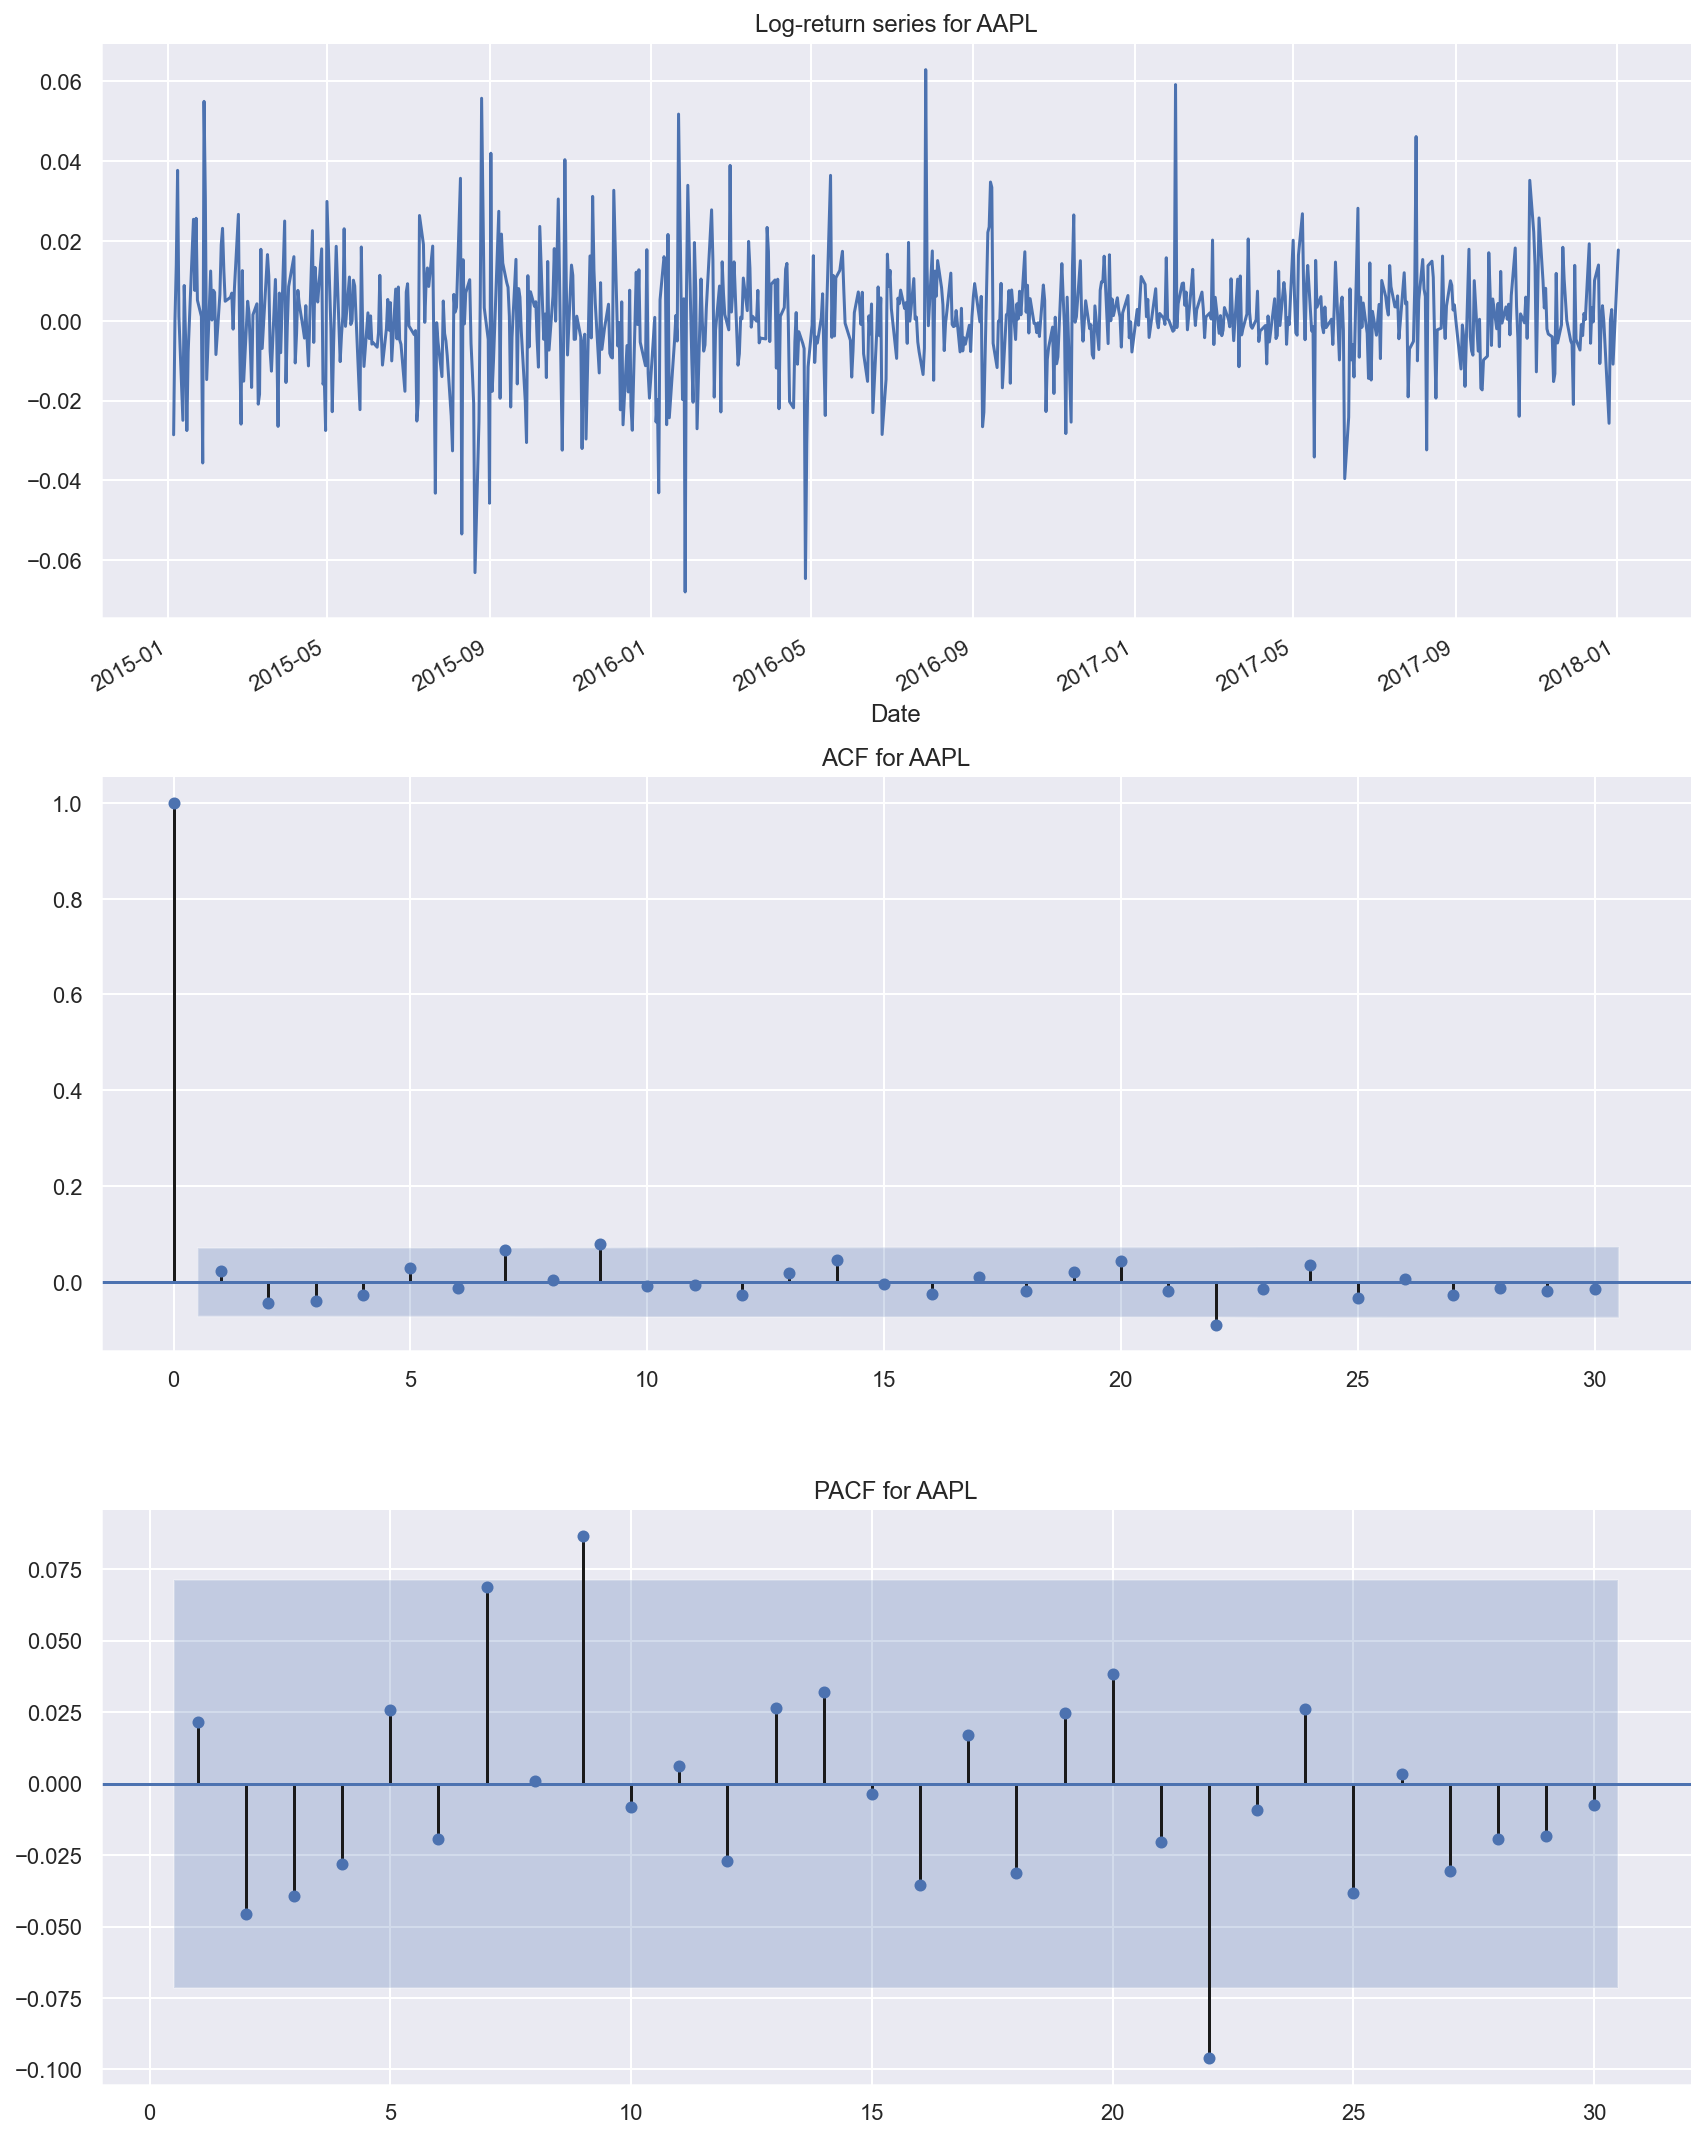

In [61]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = aapl_lr.plot(ax=ax1,title='Log-return series for AAPL')
_ = plot_acf(aapl_lr, ax=ax2,zero = True,alpha=0.05,lags=30,title='ACF for AAPL')
_ = plot_pacf(aapl_lr, ax=ax3, zero = False,alpha=0.05,lags=30,title='PACF for AAPL')
sns.despine()
plt.tight_layout()
plt.show()



The ACF and APCF show ery little significance in the first 10 lags impliying that there is no serial correlation in the log returns. We also run the LJung-Box test:

In [62]:
acorr_ljungbox(aapl_lr,lags=1,return_df=True)

,lb_stat,lb_pvalue
1,0.350986,0.553556


The pvalue is high implying we cannot reject the null that there is no serial correlation

#### Part 2

In [67]:
pivot_1 = (aapl.High + aapl.Low)/2
pivot_2 = (aapl.High + aapl.Low + aapl.Close)/3
p1_lr = np.log(pivot_1).diff().dropna()
p2_lr = np.log(pivot_2).diff().dropna()

In [68]:
acorr_ljungbox(p1_lr,lags=1,return_df=True)

,lb_stat,lb_pvalue
1,12.4846,0.00041


In [69]:
acorr_ljungbox(p2_lr,lags=1,return_df=True)

,lb_stat,lb_pvalue
1,22.454746,0.000002


For both the 2 pivots the pvalues are small and thus we can reject the null that there is no serial correlation at lag 1.

### Exercise 6

Consider the daily price of Apple stock again in file aapl_daily.csv.
1. Compute various measures of variance computed from the entries of the price bars. Comment on their correlation with log volume.
2. Use the ARIMA modeling to come up with a parsimoniousmodel for log volume. Comment on the model accuracy by setting aside a validation data set.
<br>

#### Part 1

We create the volatility estimates suggested in the book using the same framework suggested on page 144. The measures are:
- Close to Close
- Rogers & Satchell
- Yang & Zhang

We look at the over a choose 22d (1 month) period. (Note the use of groupby and pd.grouper since we want to look at this not on a rolling window but as in non overlapping periods). 

In [178]:
def vol_estimates(df):
    o = np.log(df.Open) - np.log(df.Close.shift())
    u = np.log(df.High) - np.log(df.Open)
    d = np.log(df.Low) - np.log(df.Open)
    c = np.log(df.Close) - np.log(df.Open)
    
    n = c.shape[0]
    k = 0.34/(1.34 + (n+1)*(n-1))

    v_cc = ((o + c) - (o.mean()+c.mean())).pow(2).sum()/(n-1)
    v_rs = (u*(u-c) + d*(d-c)).sum()/n

    v_yz = (o - o.mean()).pow(2).sum()/(n-1) + k*(c - c.mean()).pow(2).sum()/(n-1) + (1-k)*v_rs
    
    return pd.Series({'Vcc':v_cc,'Vrs':v_rs,'Vyz':v_yz})

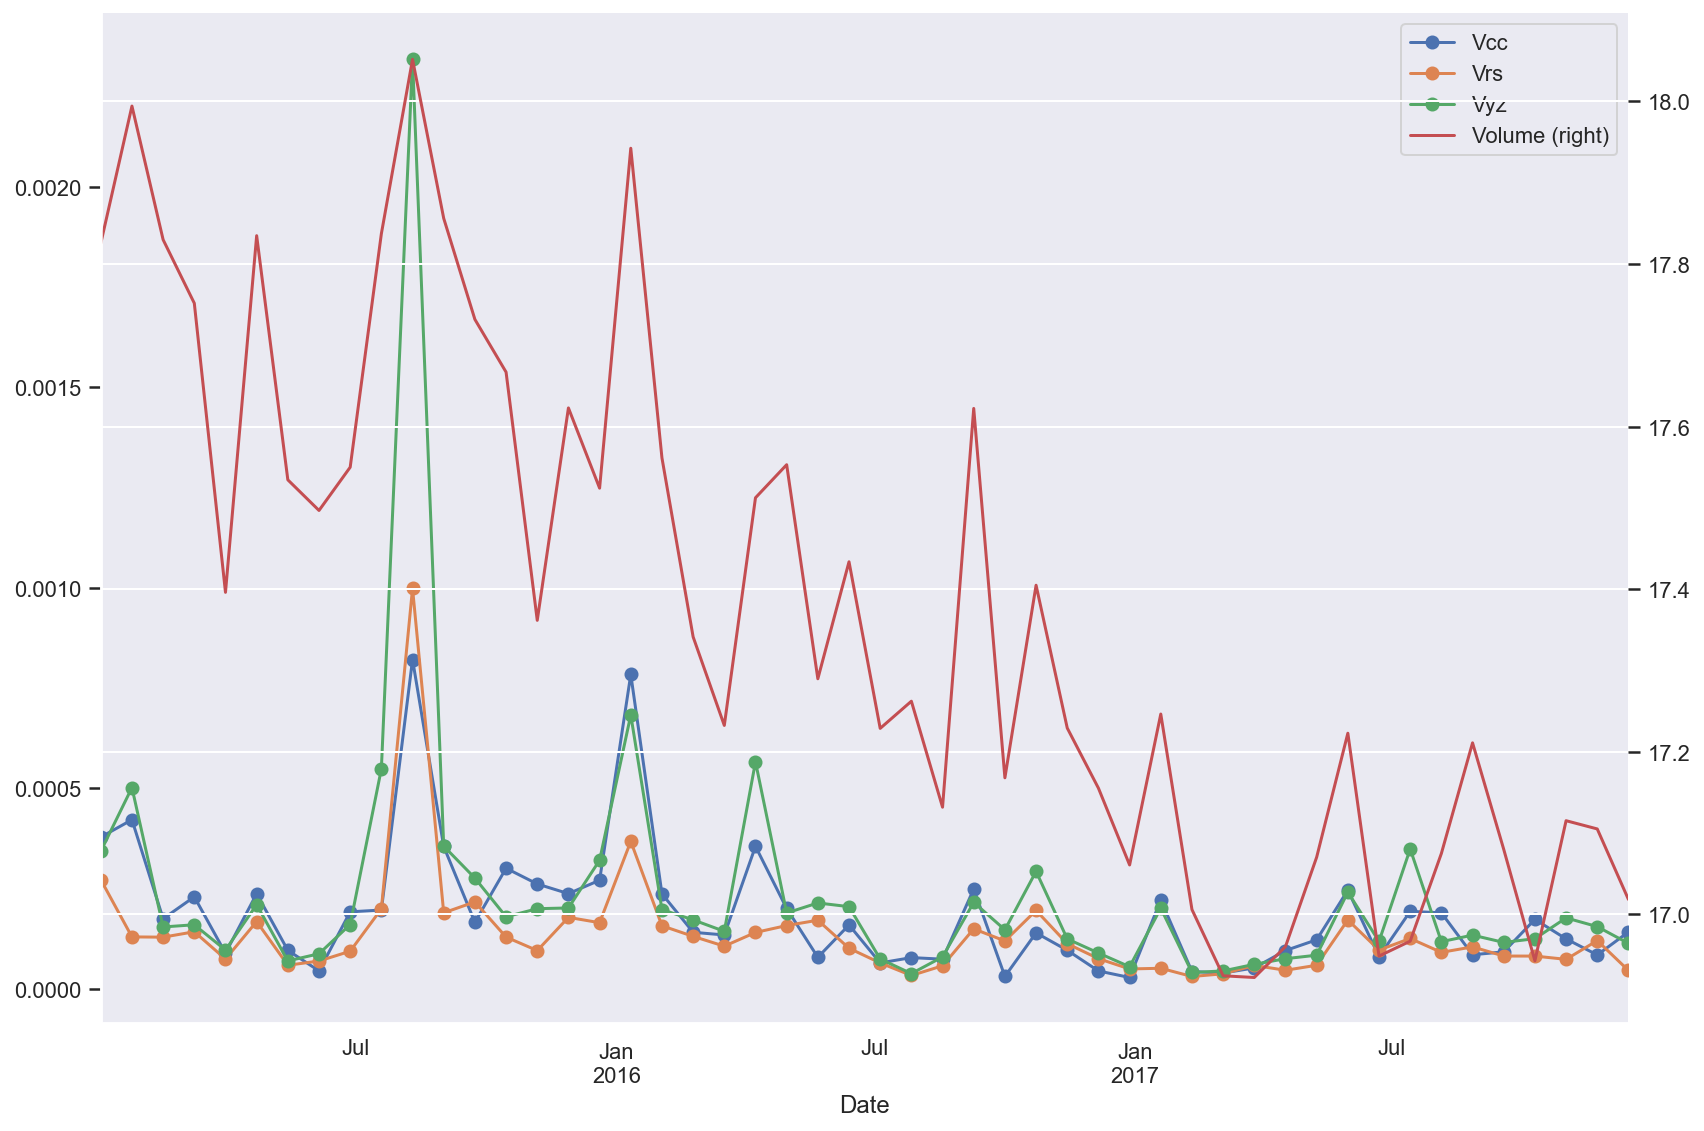

In [179]:
vol_measures = aapl.groupby(pd.Grouper(freq='22d')).apply(vol_estimates)
log_volume =  aapl.Volume.groupby(pd.Grouper(freq='22d')).apply(lambda x: np.log(x).mean())
fig,ax = plt.subplots(figsize=(12,8))
_ = vol_measures.iloc[:,0:3].plot(ax=ax,linestyle='-',marker='o')
_ = log_volume.plot(ax=ax,secondary_y=True,label=None,legend=True)
sns.despine()
plt.tight_layout()
plt.show()


Let's look at the correlation of each measure with  log volume.

In [180]:
vol_measures.corrwith(log_volume)

Vcc    0.700254
Vrs    0.574676
Vyz    0.528924
dtype: float64

#### Part 2



In [191]:
log_volume = np.log(aapl.Volume)

logv_train = log_volume[:-60]
logv_val = log_volume[-60:]

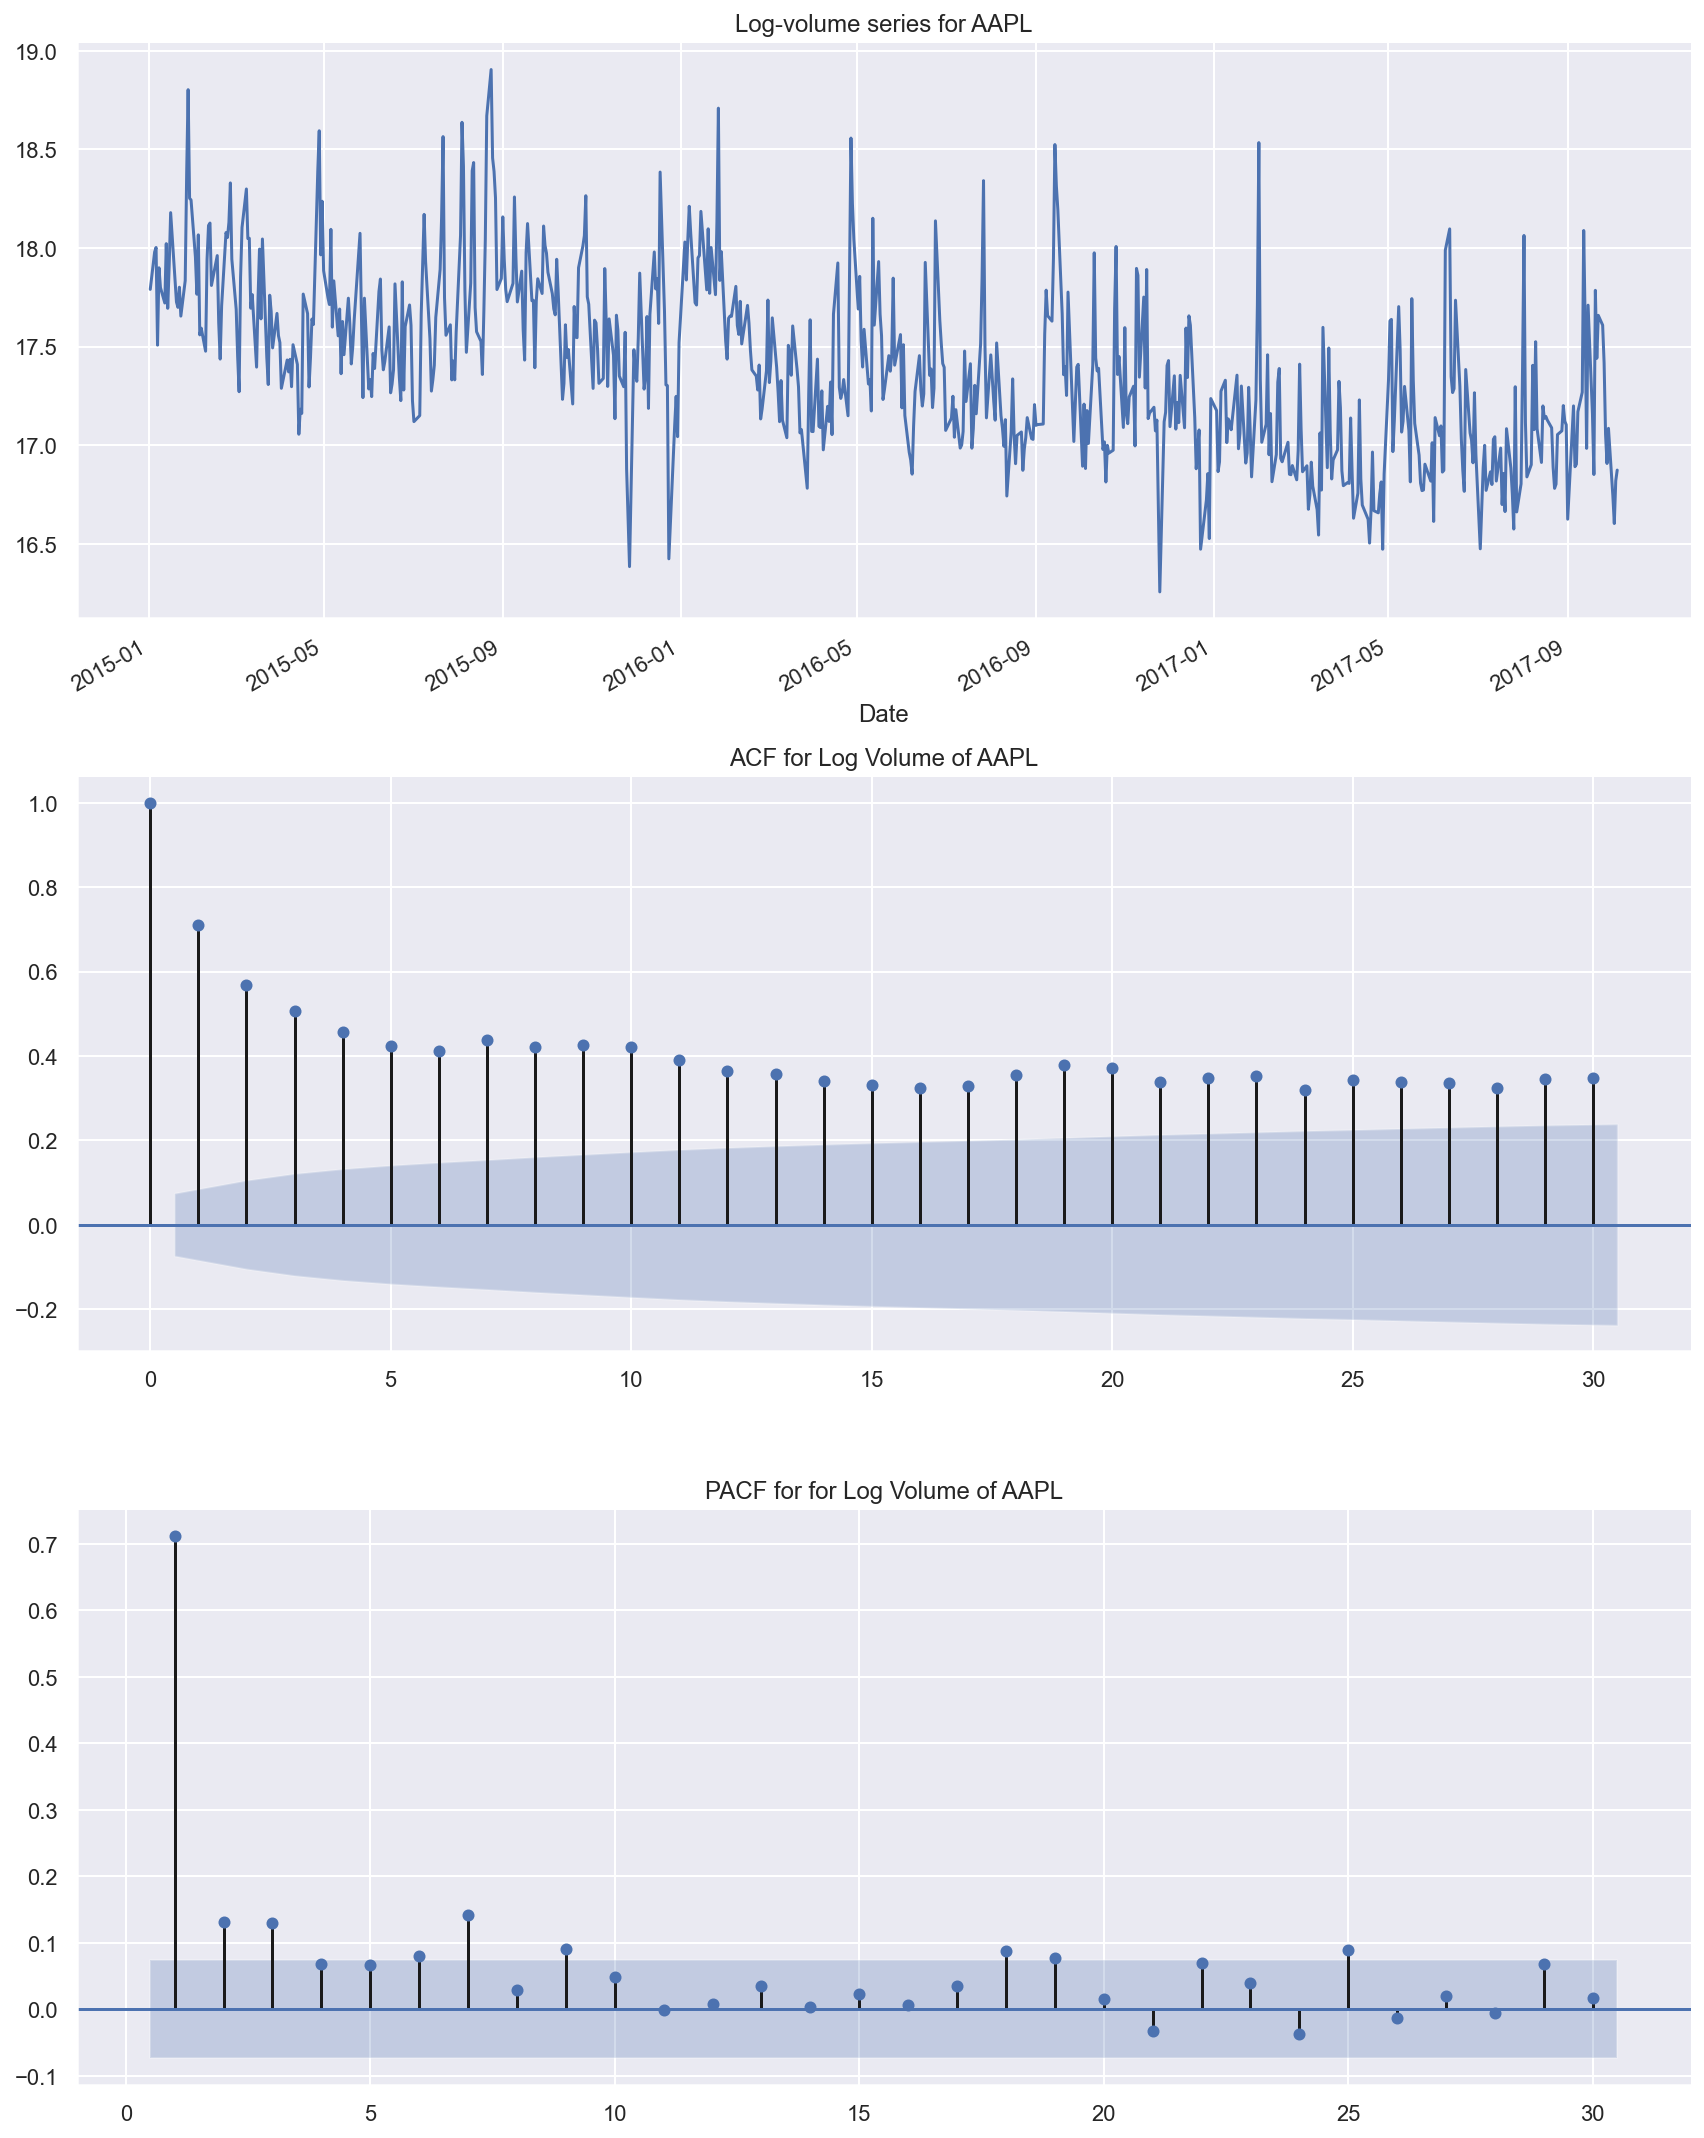

In [192]:

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = logv_train.plot(ax=ax1,title='Log-volume series for AAPL')
_ = plot_acf(logv_train, ax=ax2,zero = True,alpha=0.05,lags=30,title='ACF for Log Volume of AAPL')
_ = plot_pacf(logv_train, ax=ax3, zero = False,alpha=0.05,lags=30,title='PACF for for Log Volume of AAPL')
sns.despine()
plt.tight_layout()
plt.show()

ACF is highly significant across many lags so there is autocorrelation. PACF is significant at lag 1,2, and 3.

Let's look at the differenced data:

In [195]:
logv_diff = logv_train.diff().dropna()

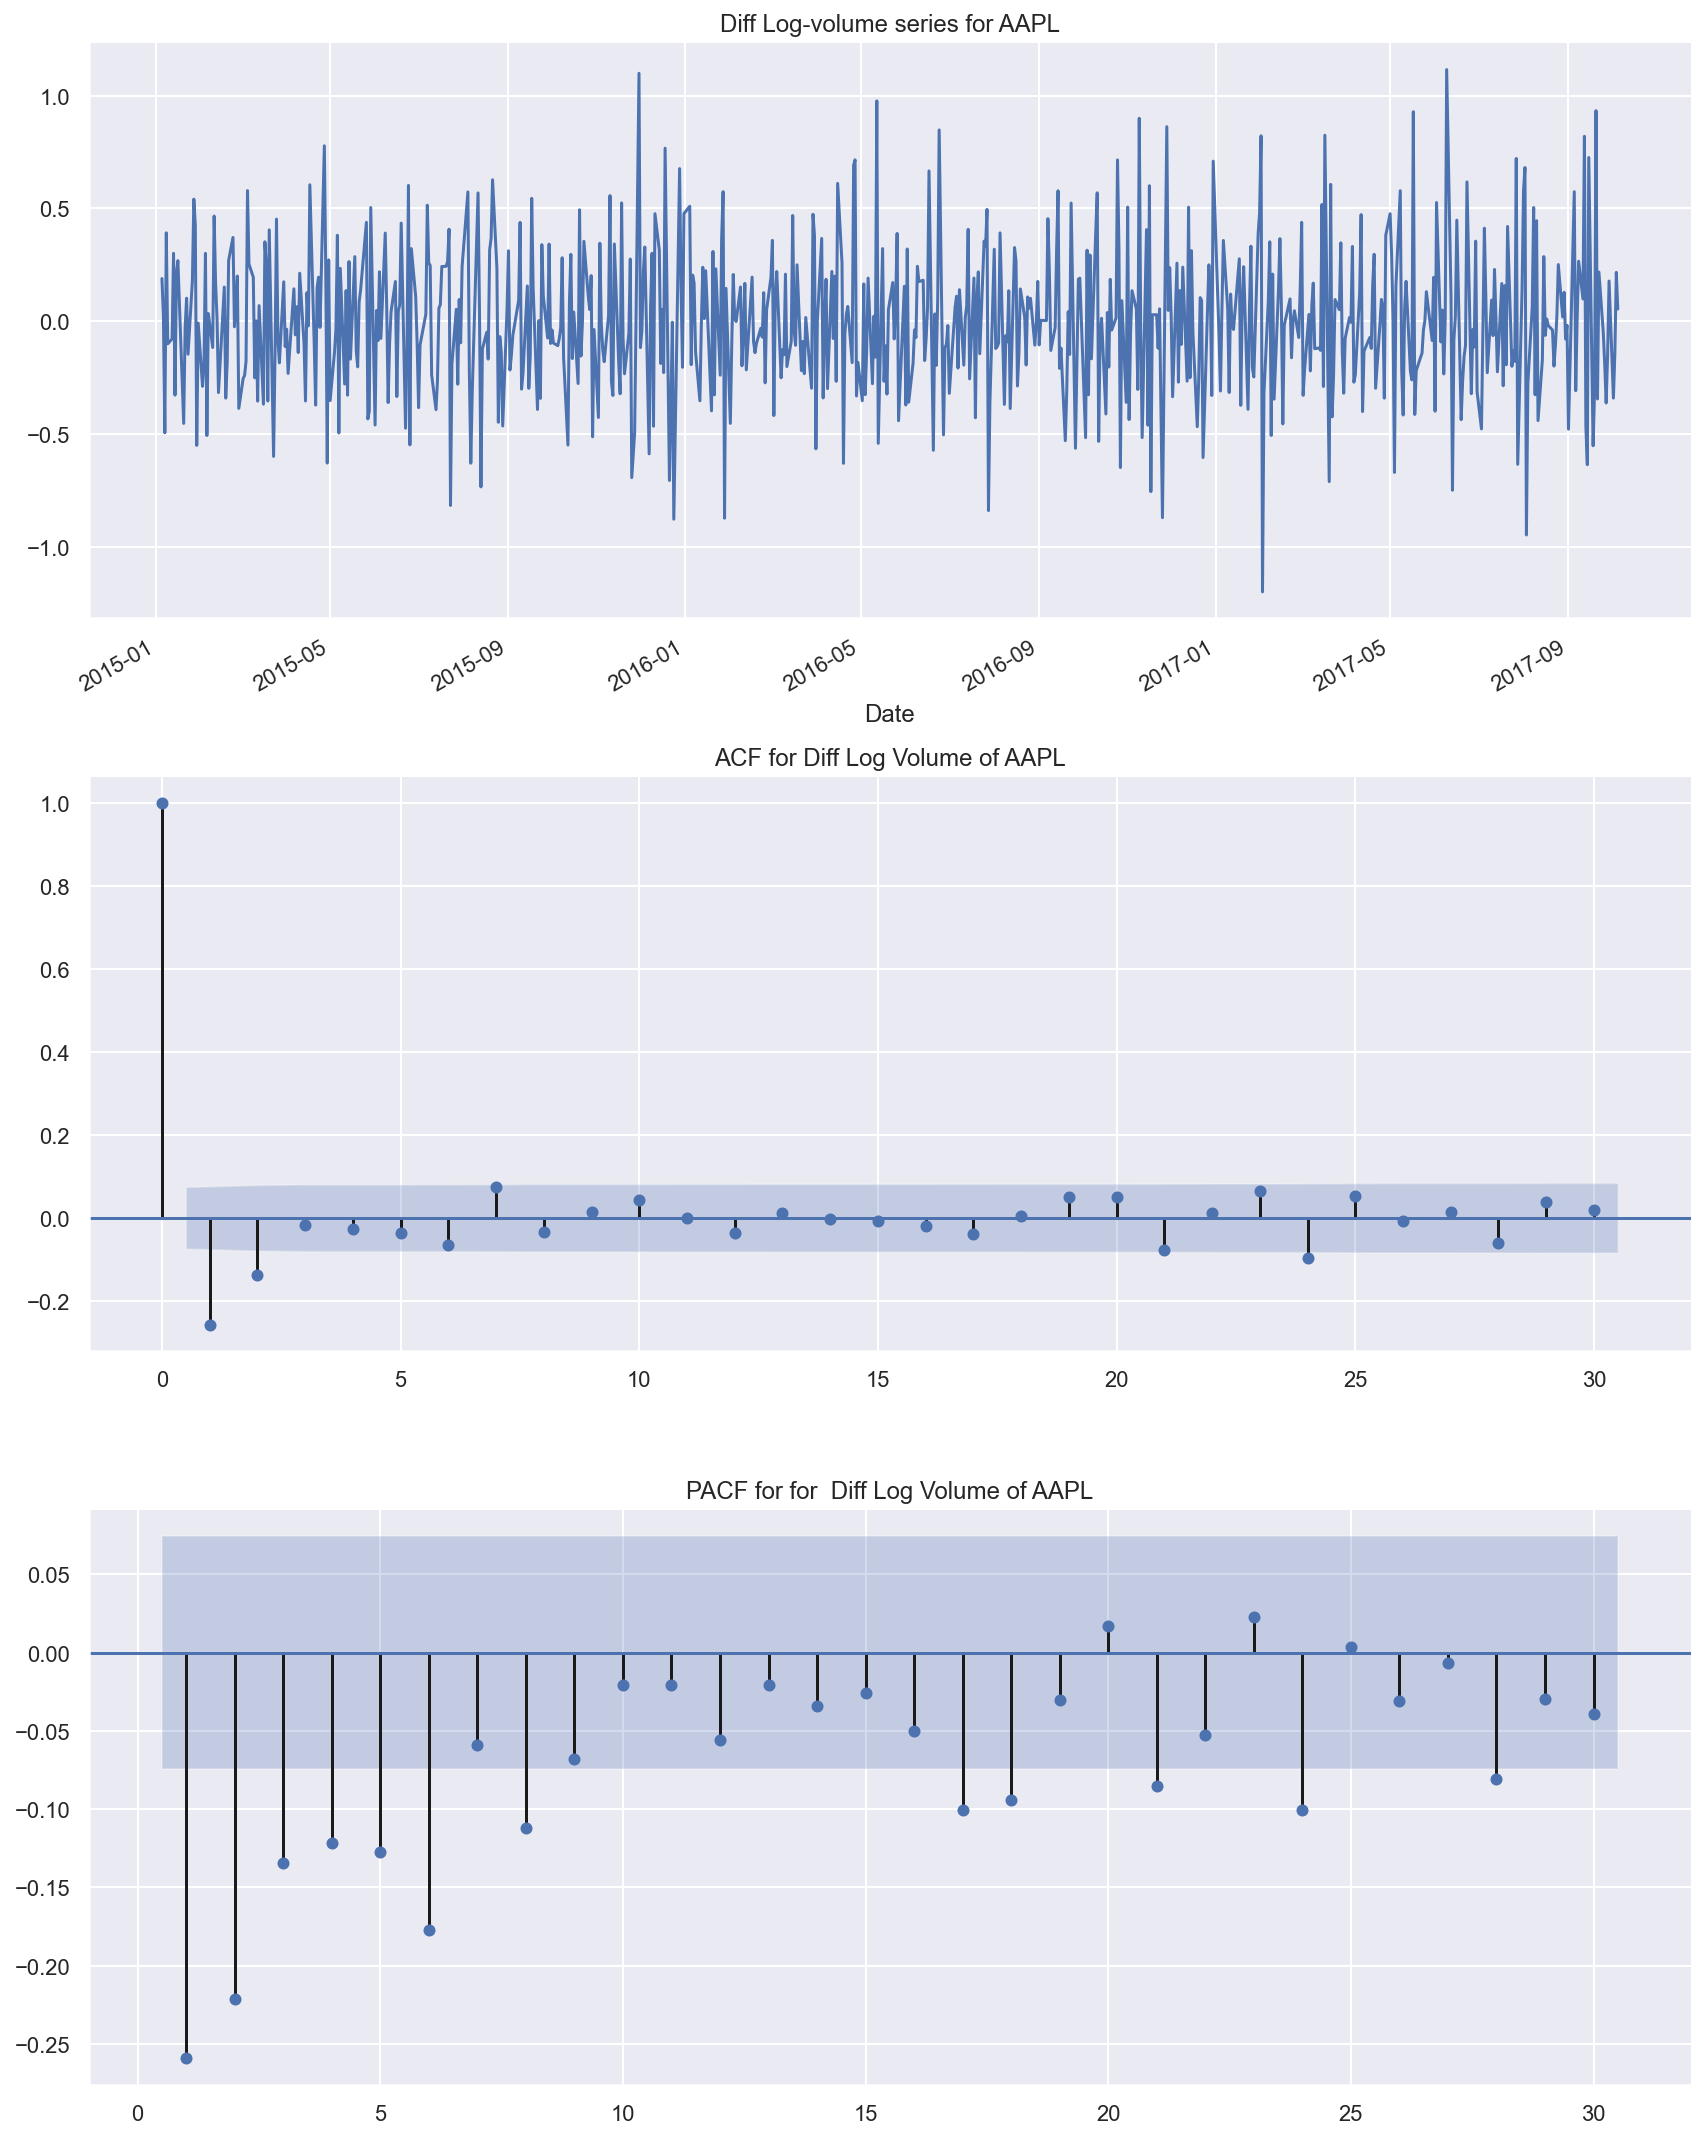

In [196]:

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = logv_diff.plot(ax=ax1,title='Diff Log-volume series for AAPL')
_ = plot_acf(logv_diff, ax=ax2,zero = True,alpha=0.05,lags=30,title='ACF for Diff Log Volume of AAPL')
_ = plot_pacf(logv_diff, ax=ax3, zero = False,alpha=0.05,lags=30,title='PACF for Diff Log Volume of AAPL')
sns.despine()
plt.tight_layout()
plt.show()

After differencing the ACF is signficant at lag 1 and 2. the PACF is significant over several lags. Let's try first with ARMA(3,2).

In [280]:
model = ARIMA(logv_train,(3,1,2))

In [281]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Volume   No. Observations:                  695
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -134.341
Method:                       css-mle   S.D. of innovations              0.292
Date:                Tue, 15 Sep 2020   AIC                            282.683
Time:                        12:51:35   BIC                            314.490
Sample:                             1   HQIC                           294.982
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013      0.000    -10.106      0.000      -0.002      -0.001
ar.L1.D.Volume    -0.4065      0.091     -4.478      0.000      -0.584      -0.229
ar.L2.D.Volume     0.5231      0.063      8.347      0.000       0.400       0.646
ar.L3.D.Volume     0.0657      0.039      1.669      0.095      -0.011       0.143
ma.L1.D.Volume    -0.0638      0.084     -0.762      0.446      -0.228       0.100
ma.L2.D.Volume    -0.9362      0.084    -11.185      0.000      -1.100      -0.772
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1055           +0.0000j            1.1055            0.5000
AR.2            1.6236           +0.0000j            1.6236            0.0000
AR.3           -8.4844           +0.0000j            8.4844            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0681           +0.0000j            1.0681            0.5000
-----------------------------------------------------------------------------
"""

The L3 AR coefficient is non significant and so is the L1 MA coefficient. Let's try a more parsimonus model to ARMA(1,1)

In [286]:
model = ARIMA(logv_train,(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Volume   No. Observations:                  695
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -136.600
Method:                       css-mle   S.D. of innovations              0.293
Date:                Tue, 15 Sep 2020   AIC                            281.200
Time:                        12:52:53   BIC                            299.375
Sample:                             1   HQIC                           288.228
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013      0.000    -10.688      0.000      -0.002      -0.001
ar.L1.D.Volume     0.5511      0.032     17.370      0.000       0.489       0.613
ma.L1.D.Volume    -1.0000      0.005   -202.173      0.000      -1.010      -0.990
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8145           +0.0000j            1.8145            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

All Coefficients are significant and the AIC/BIC has improved. So we settle to an ARMA(1,1)

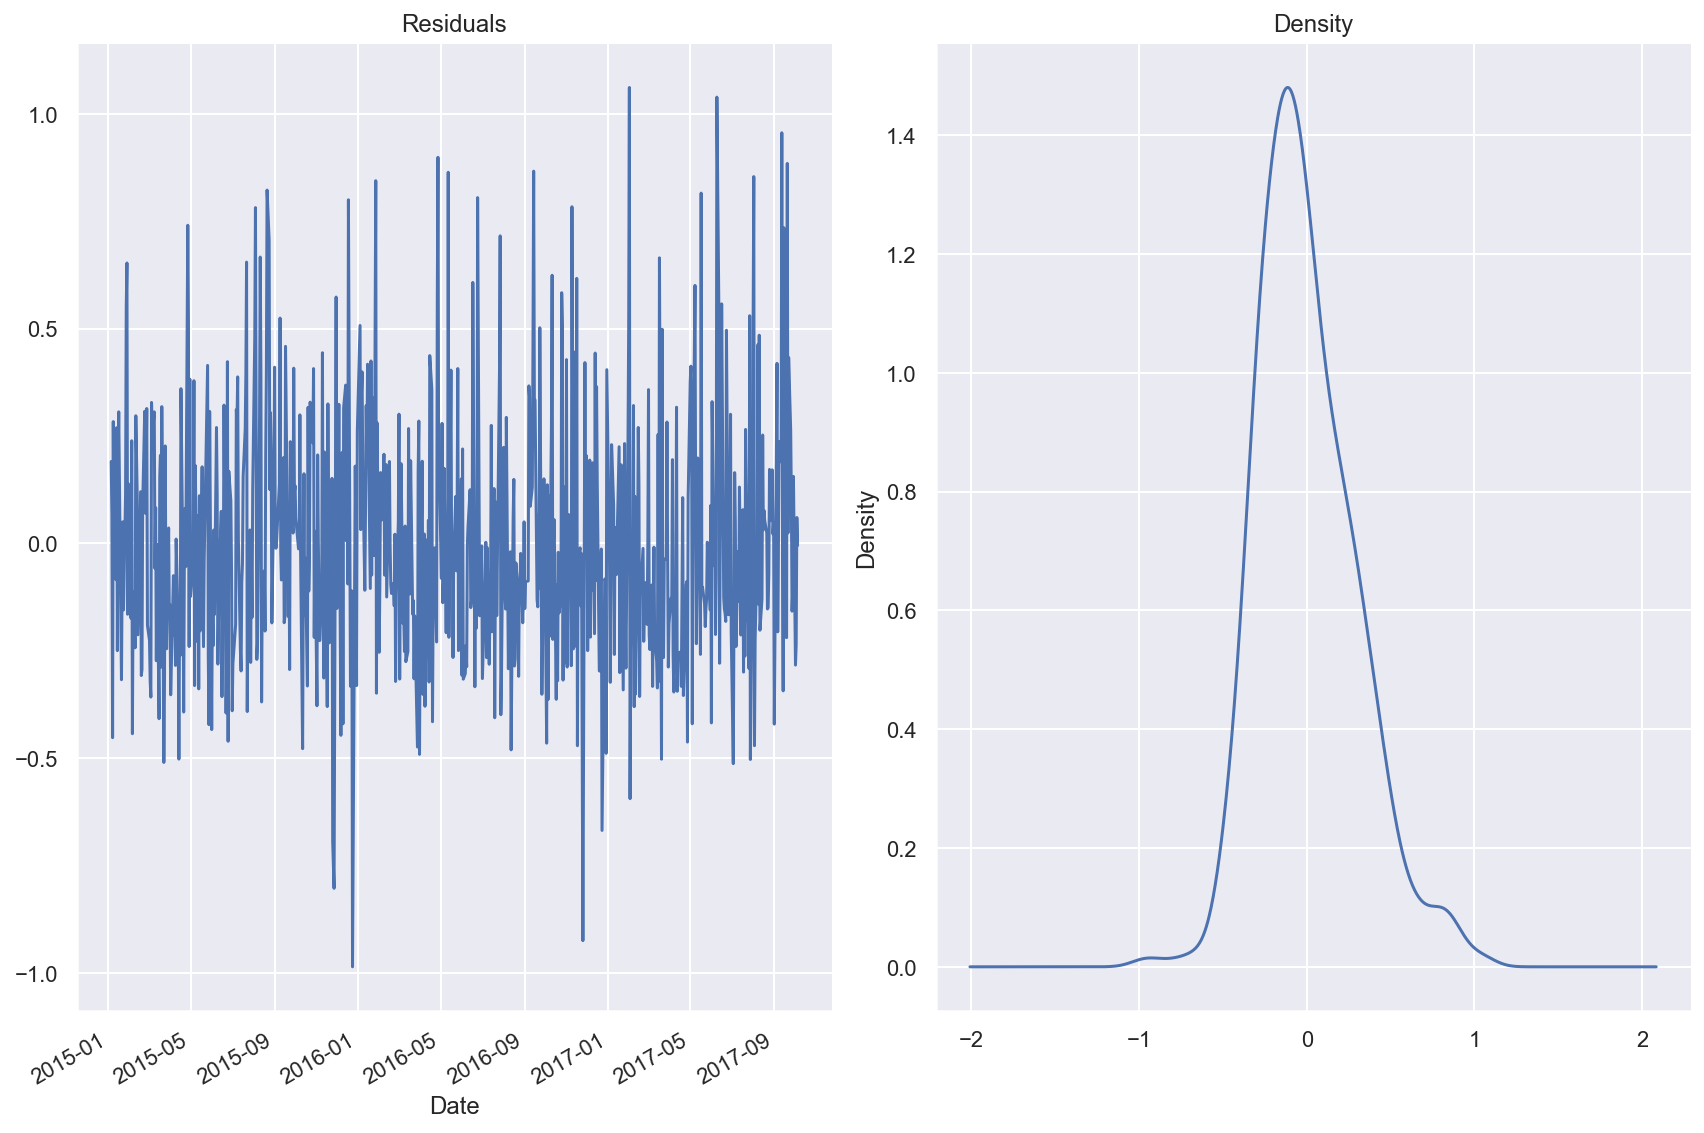

In [292]:
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2,figsize=(12,8))
residuals.plot(title="Residuals", ax=ax[0],legend=False)
residuals.plot(kind='kde', title='Density', ax=ax[1],legend=False)
plt.tight_layout()
sns.despine()
plt.show()

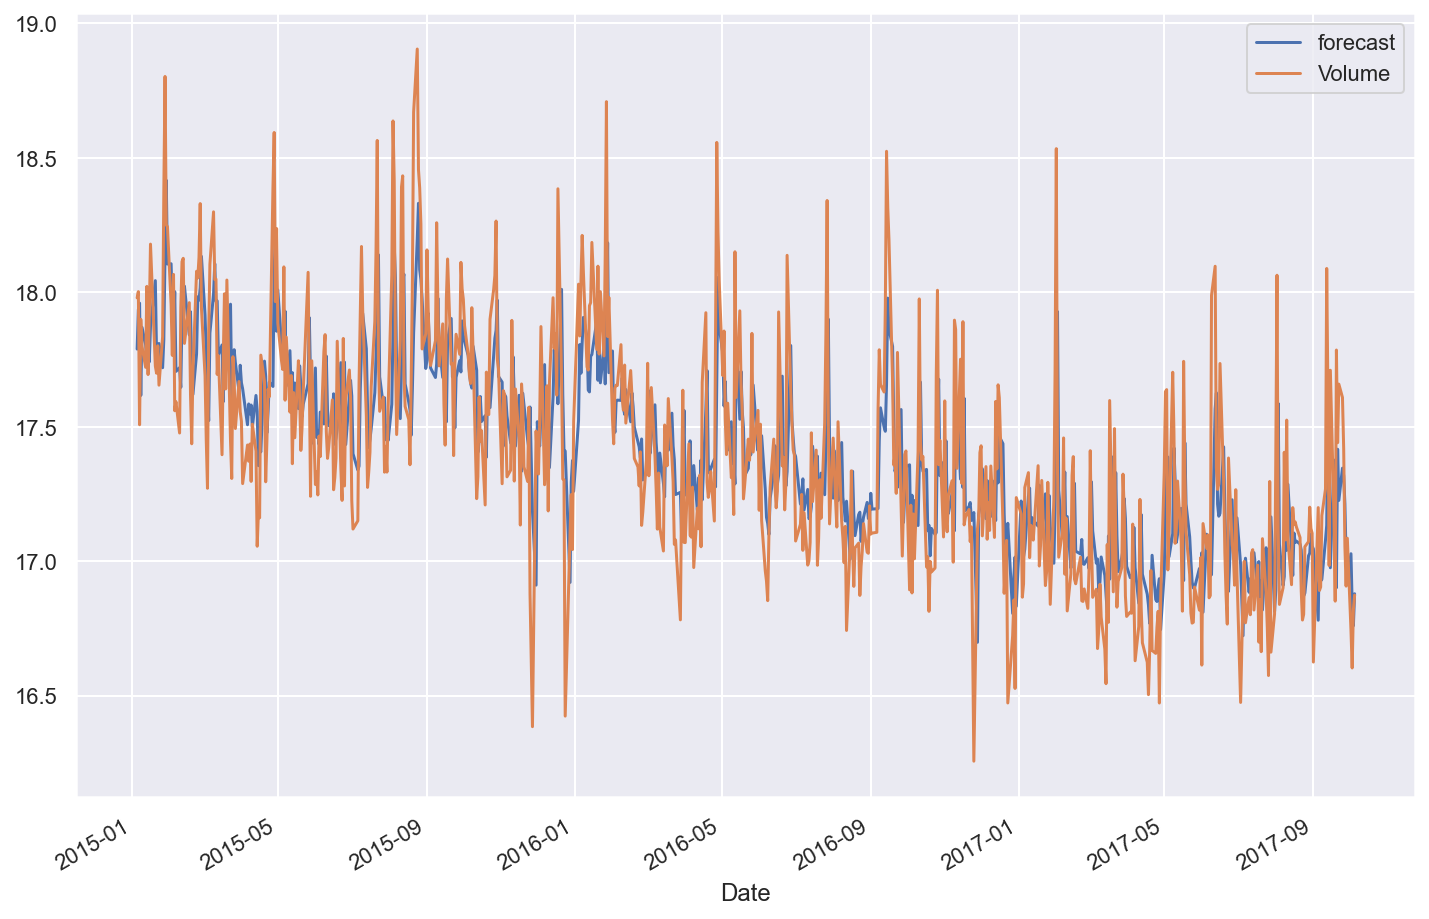

In [296]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
results.plot_predict(dynamic=False,ax=ax)
plt.show()